In [100]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import os

def plot_sir(exp_name, beta, gamma):
    plt.rcParams["figure.figsize"] = [7.00, 3.50]
    plt.rcParams["font.size"] = 12.0
    plt.rcParams["figure.autolayout"] = True

    base_path = f"../../src/InfoWave.MonoGame/bin/Release/net7.0/experiments/{exp_name}/"
    folders = os.listdir(base_path)
    dfs = []
    for filename in folders:
        path = os.path.join(base_path, filename)
        df = pd.read_csv(path)
        dfs.append(df)
    combined_df = pd.concat(dfs)
    grouped_df = combined_df.groupby('t').agg({'s': ['min', 'max', 'median'], 'i': ['min', 'max', 'median'], 'r': ['min', 'max', 'median']})
    grouped_df.columns = ['s_min', 's_max', 's_median', 'i_min', 'i_max', 'i_median', 'r_min', 'r_max', 'r_median']

    # Parameters for the SIR model
    # beta = 0.125   # infection rate
    # gamma = 0.05  # recovery rate
    N = 40     # total population

    # Calculate the reference SIR model
    def sir_model(y, t):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    # Time points for the SIR model
    t_model = grouped_df.index.values

    # Initial conditions for the SIR model
    y0 = (N, 1, 0)  # (S0, I0, R0)

    # Integrate the SIR model equations
    from scipy.integrate import odeint
    sol = odeint(sir_model, y0, t_model)

    plt.figure(figsize=(10, 6))

    # Define color and alpha values
    color = 'steelblue'
    area_alpha = 0.1
    point_alpha = 0.3

    # Plotting susceptible
    plt.fill_between(grouped_df.index, grouped_df['s_min'], grouped_df['s_max'], color='g', alpha=area_alpha)
    plt.plot(grouped_df.index, grouped_df['s_median'], marker='o', color='g', alpha=point_alpha, label='Susceptible')

    # Plotting infected
    plt.fill_between(grouped_df.index, grouped_df['i_min'], grouped_df['i_max'], color='r', alpha=area_alpha)
    plt.plot(grouped_df.index, grouped_df['i_median'], marker='o', color='r', alpha=point_alpha, label='Infected')

    # Plotting recovered
    plt.fill_between(grouped_df.index, grouped_df['r_min'], grouped_df['r_max'], color='b', alpha=area_alpha)
    plt.plot(grouped_df.index, grouped_df['r_median'], marker='o', color='b', alpha=point_alpha, label='Removed')

    # Plotting the reference SIR model
    plt.plot(t_model, sol[:, 0], label='SIR Model (Susceptible)', linestyle='--', color='g')
    plt.plot(t_model, sol[:, 1], label='SIR Model (Infected)', linestyle='--', color='r')
    plt.plot(t_model, sol[:, 2], label='SIR Model (Removed)', linestyle='--', color='b')

    plt.xlabel('Time Step')
    plt.ylabel('Population Size')
    # plt.title(f'Min, Max, and Median of {len(folders)} Runs (SIR parameters: beta={beta}, gamma={gamma}, N={N})')
    plt.title(f'Min, Max, and Median of {len(folders)} Runs')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"experiments/{exp_name}.png", format="png", transparent=True, bbox_inches="tight")

def plot_sir_quantile(exp_name, beta, gamma, sir=True):
    plt.rcParams["figure.figsize"] = [7.00, 3.50]
    plt.rcParams["font.size"] = 12.0
    plt.rcParams["figure.autolayout"] = True

    base_path = f"../../src/InfoWave.MonoGame/bin/Release/net7.0/experiments/{exp_name}/"
    folders = os.listdir(base_path)
    dfs = []
    for filename in folders:
        path = os.path.join(base_path, filename)
        df = pd.read_csv(path)
        dfs.append(df)
    combined_df = pd.concat(dfs)
    # Group the data by the "t" column and calculate the 25th, 50th, and 75th percentiles for each time point
    grouped_df = combined_df.groupby('t')['s', 'i', 'r'].quantile([0.25, 0.5, 0.75]).unstack()


    # Parameters for the SIR model
    # beta = 0.125   # infection rate
    # gamma = 0.05  # recovery rate
    N = 40     # total population

    # Calculate the reference SIR model
    def sir_model(y, t):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    # Time points for the SIR model
    t_model = grouped_df.index.values

    # Initial conditions for the SIR model
    y0 = (N, 1, 0)  # (S0, I0, R0)

    # Integrate the SIR model equations
    from scipy.integrate import odeint
    sol = odeint(sir_model, y0, t_model)

    plt.figure(figsize=(10, 6))

    # Define color and alpha values
    color = 'steelblue'
    area_alpha = 0.1
    point_alpha = 0.3

    # Plotting susceptible
    plt.fill_between(grouped_df.index, grouped_df['s', 0.25], grouped_df['s', 0.75], color='steelblue', alpha=0.3, label='Susceptible (50% range)')
    plt.plot(grouped_df.index, grouped_df['s', 0.5], marker='o', color='steelblue', label='Susceptible (Median)')

    # Plotting infected
    plt.fill_between(grouped_df.index, grouped_df['i', 0.25], grouped_df['i', 0.75], color='orange', alpha=0.3, label='Infected (50% range)')
    plt.plot(grouped_df.index, grouped_df['i', 0.5], marker='o', color='orange', label='Infected (Median)')

    # Plotting recovered
    plt.fill_between(grouped_df.index, grouped_df['r', 0.25], grouped_df['r', 0.75], color='green', alpha=0.3, label='Recovered (50% range)')
    plt.plot(grouped_df.index, grouped_df['r', 0.5], marker='o', color='green', label='Recovered (Median)')

    # Plotting the reference SIR model
    if sir:
        plt.plot(t_model, sol[:, 0], label='SIR Model (Susceptible)', linestyle='--', color='steelblue')
        plt.plot(t_model, sol[:, 1], label='SIR Model (Infected)', linestyle='--', color='orange')
        plt.plot(t_model, sol[:, 2], label='SIR Model (Removed)', linestyle='--', color='green')

    plt.xlabel('Time Step')
    plt.ylabel('Population Size')
    # plt.title(f'Min, Max, and Median of {len(folders)} Runs (SIR parameters: beta={beta}, gamma={gamma}, N={N})')
    title = f'Values between 25th and 75th percentile and Median of {len(folders)} Runs'
    if sir:
        title = f"{title} (SIR parameters: beta={beta}, gamma={gamma}, N={N})"
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"experiments/{exp_name}.png", format="png", transparent=True, bbox_inches="tight")

/var/folders/w_/d8kkzd6d6m9461xvb40k_xx40000gn/T/ipykernel_64488/1525182982.py:91: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df = combined_df.groupby('t')['s', 'i', 'r'].quantile([0.25, 0.5, 0.75]).unstack()
/var/folders/w_/d8kkzd6d6m9461xvb40k_xx40000gn/T/ipykernel_64488/1525182982.py:91: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df = combined_df.groupby('t')['s', 'i', 'r'].quantile([0.25, 0.5, 0.75]).unstack()


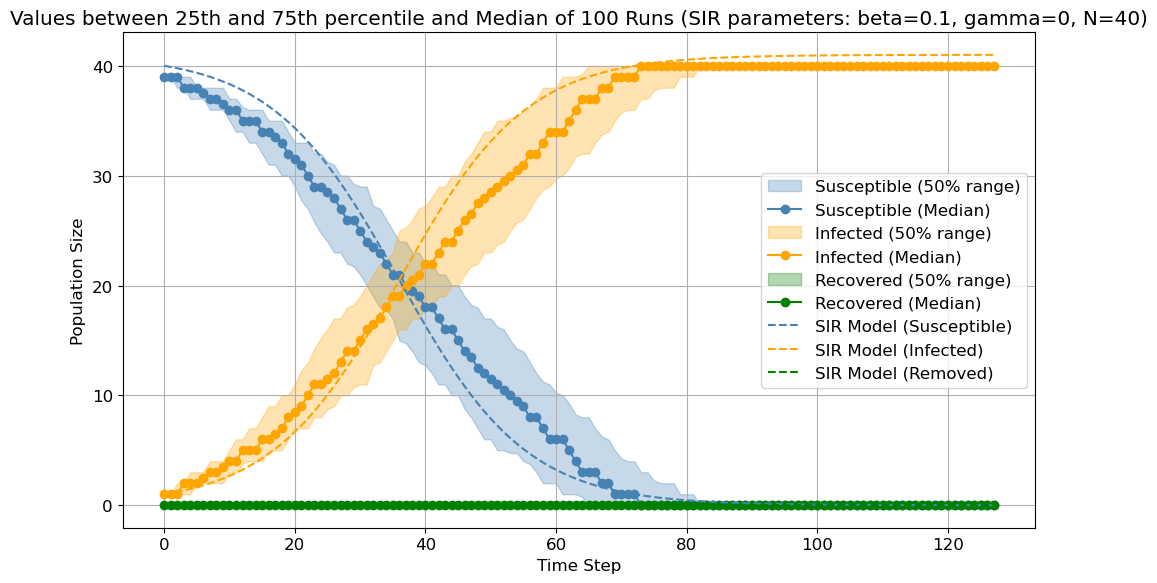

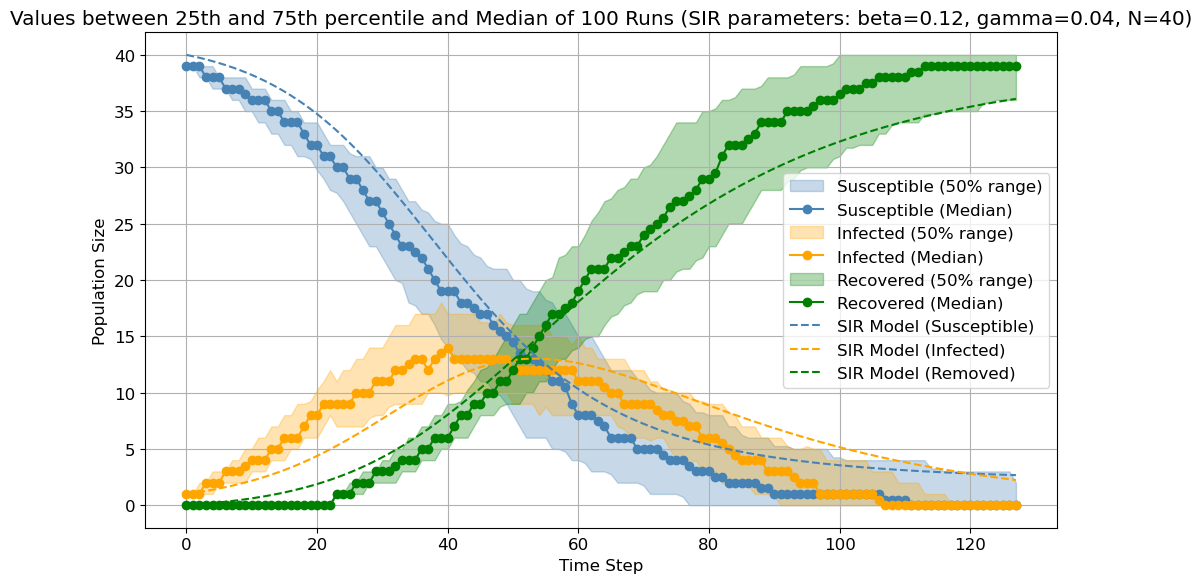

In [105]:
# plot_sir("experiment3", 0.125, 0.05)
plot_sir_quantile("experiment2", 0.10, 0)
plot_sir_quantile("experiment3", 0.12, 0.04)

/var/folders/w_/d8kkzd6d6m9461xvb40k_xx40000gn/T/ipykernel_64488/1525182982.py:91: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df = combined_df.groupby('t')['s', 'i', 'r'].quantile([0.25, 0.5, 0.75]).unstack()
/var/folders/w_/d8kkzd6d6m9461xvb40k_xx40000gn/T/ipykernel_64488/1525182982.py:91: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df = combined_df.groupby('t')['s', 'i', 'r'].quantile([0.25, 0.5, 0.75]).unstack()
/var/folders/w_/d8kkzd6d6m9461xvb40k_xx40000gn/T/ipykernel_64488/1525182982.py:91: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df = combined_df.groupby('t')['s', 'i', 'r'].quantile([0.25, 0.5, 0.75]).unstack()
/var/folders/w_/d8kkzd6d6m9461xvb40k_xx40000gn/T/ipykernel_64488/1525182982.py:91: FutureWarning:

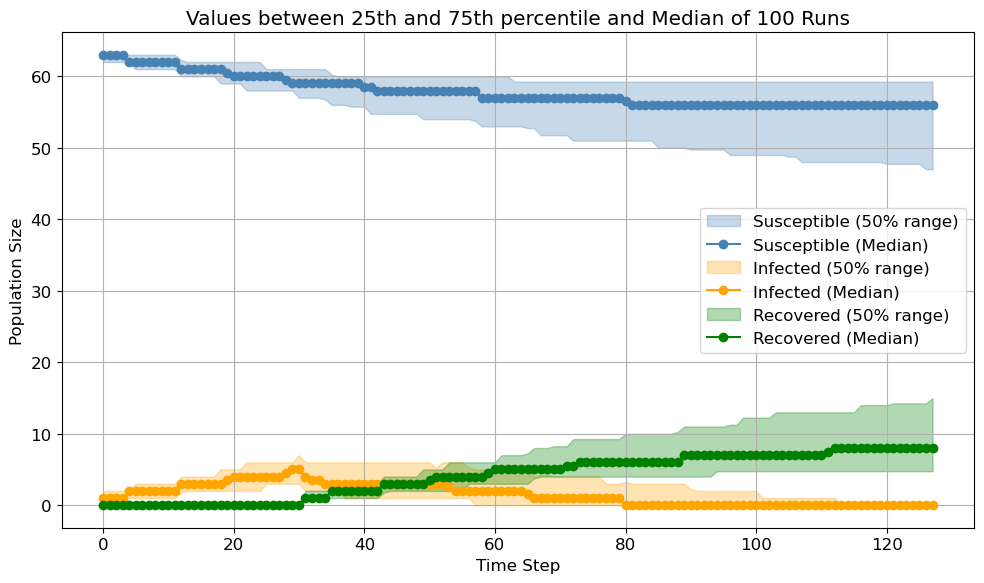

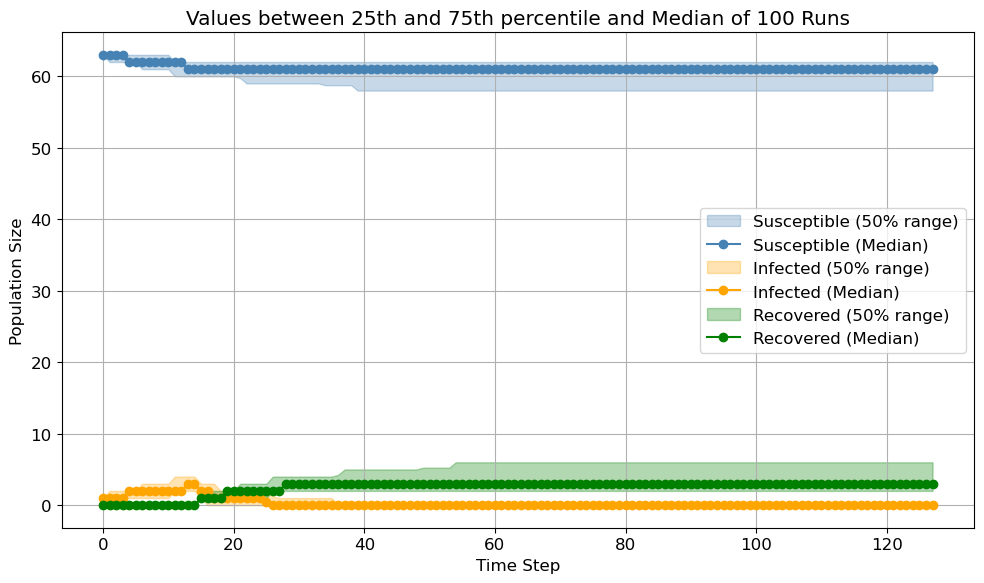

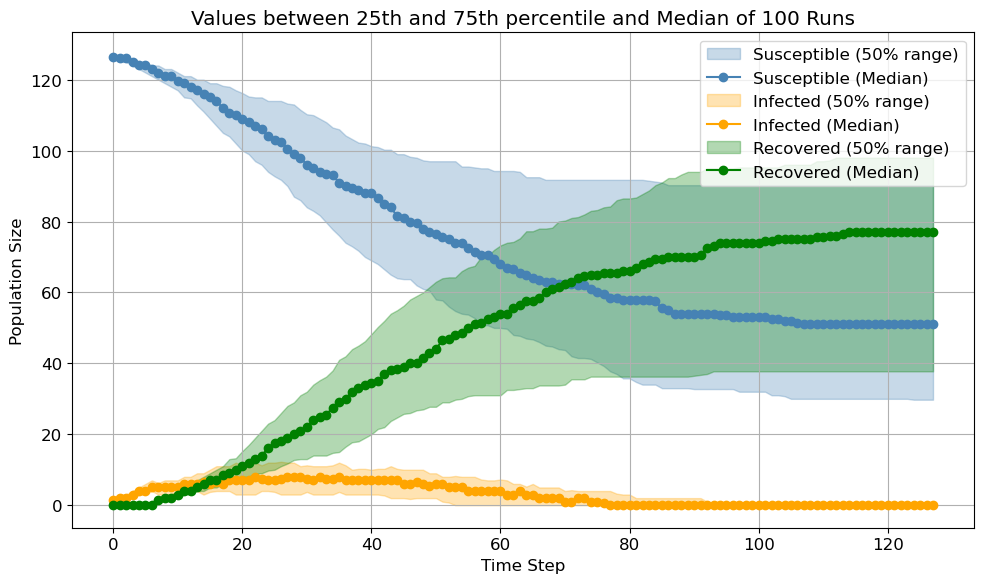

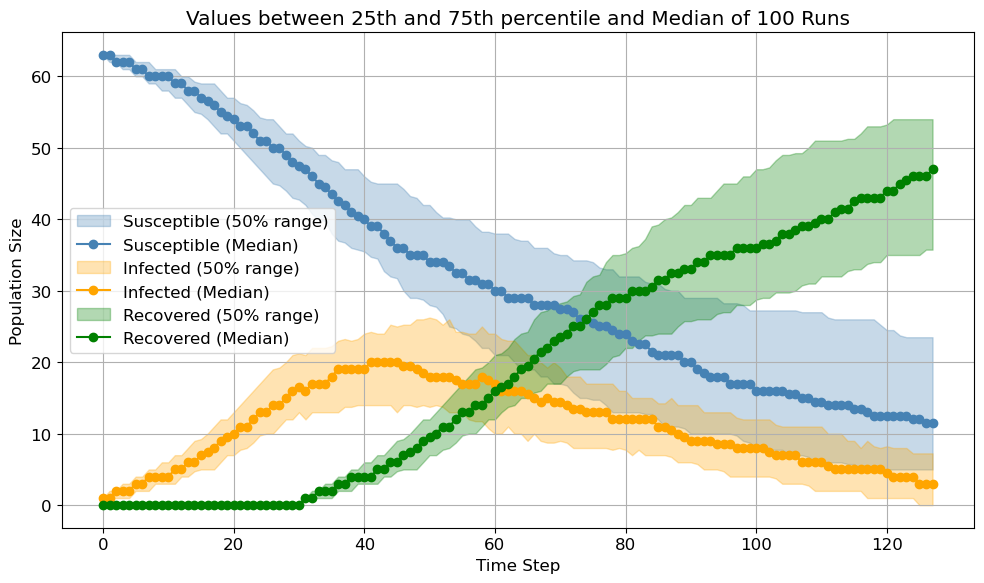

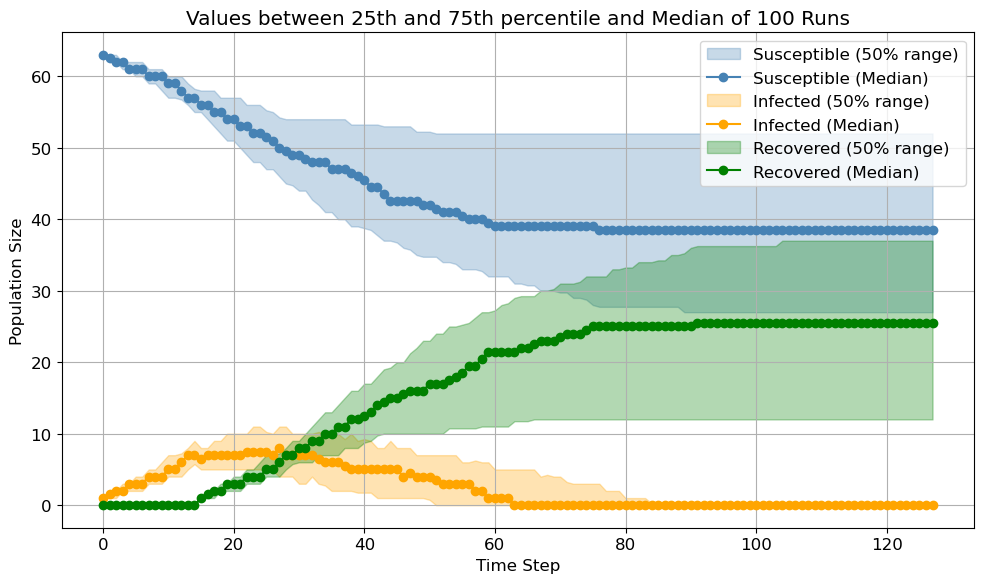

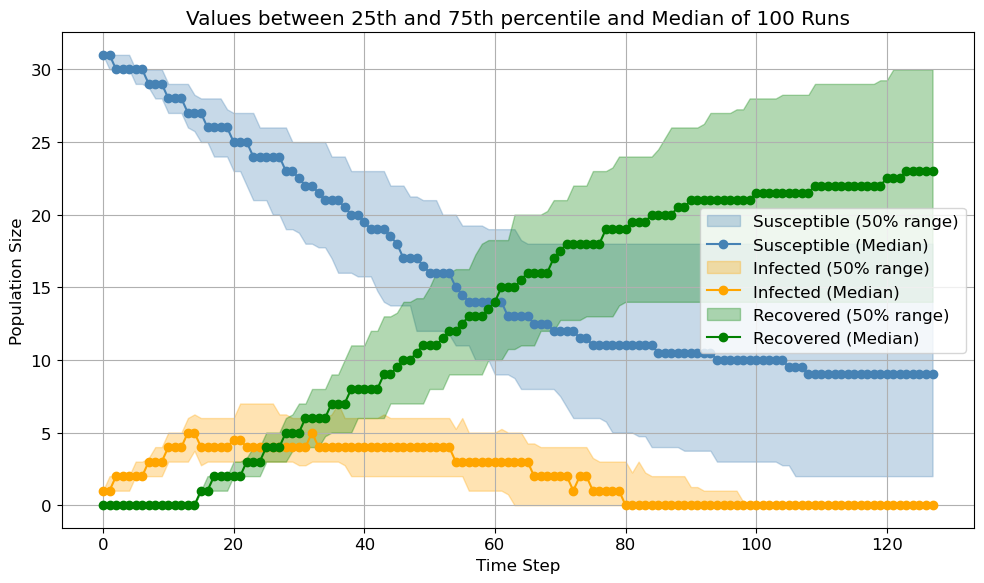

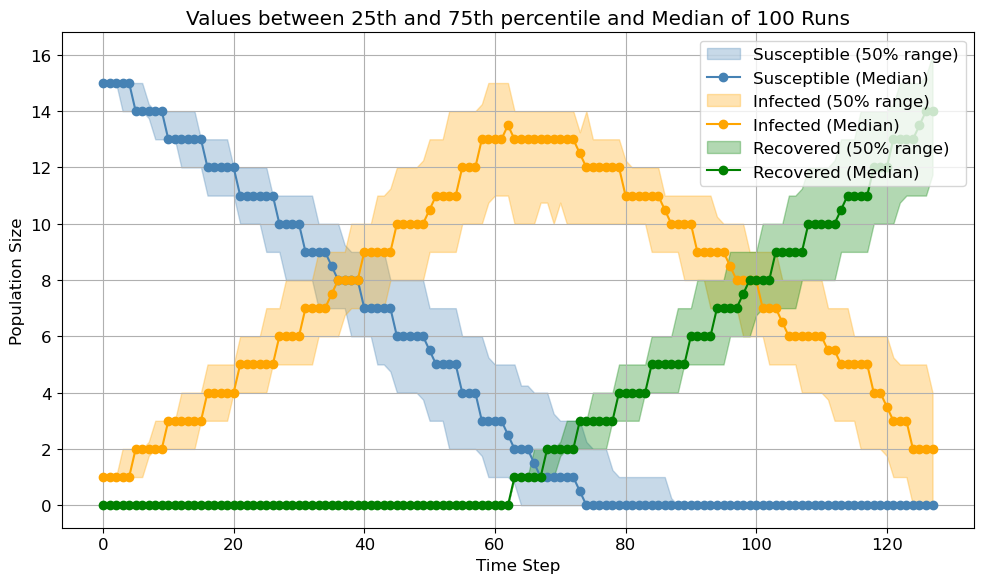

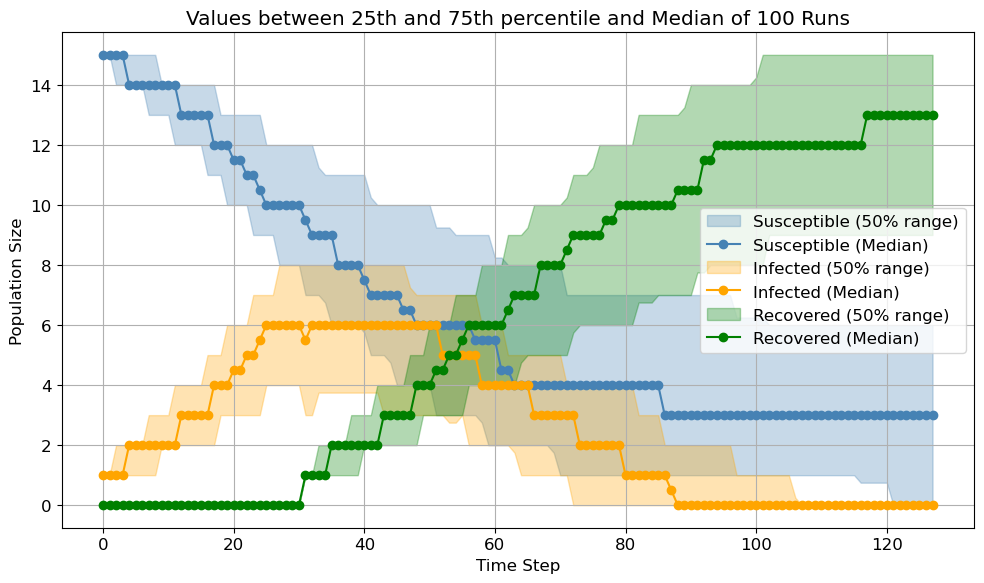

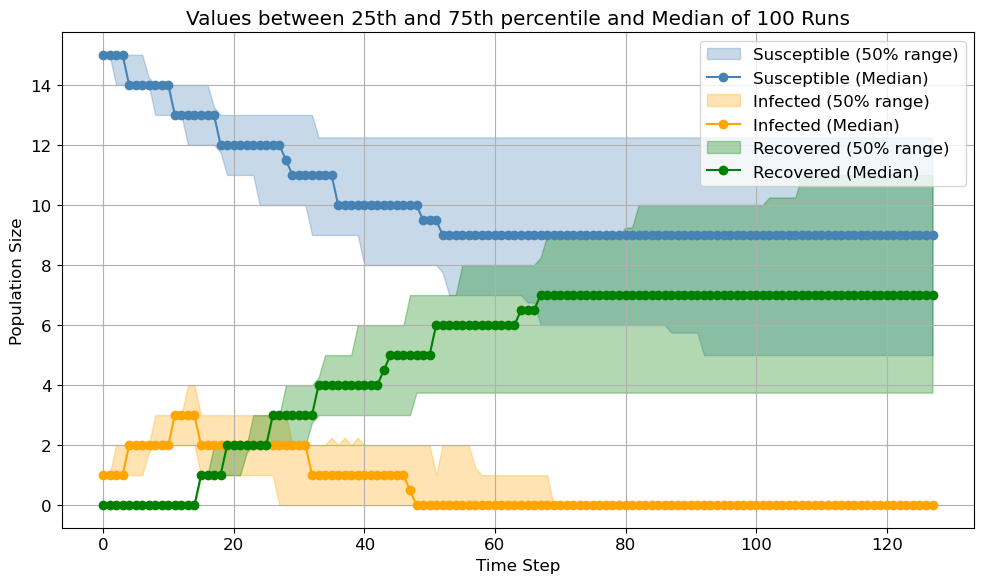

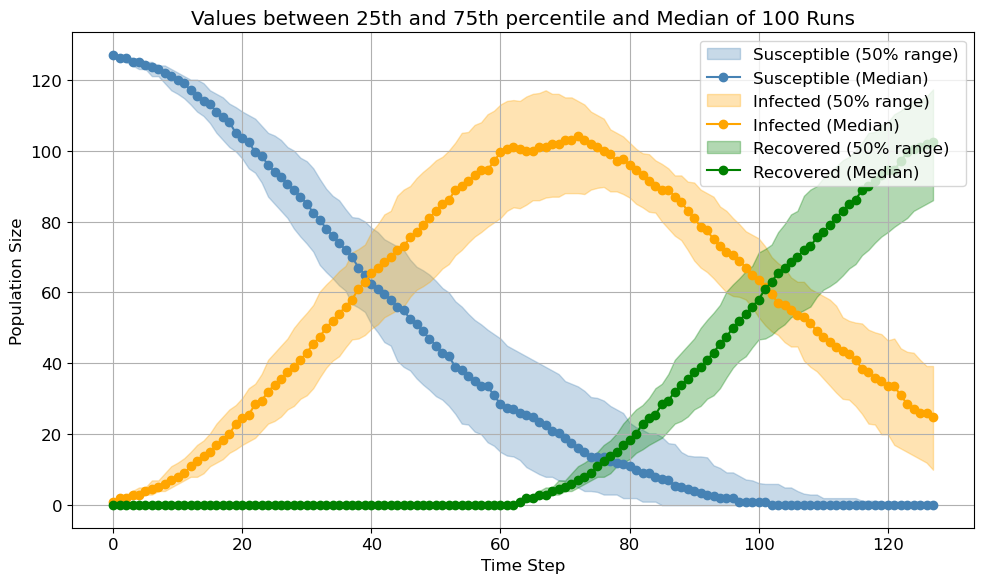

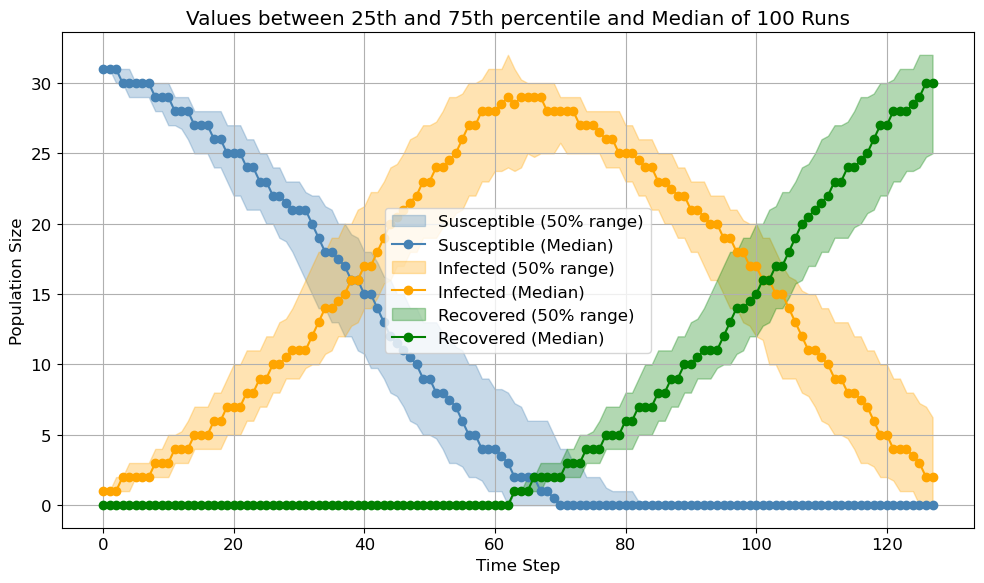

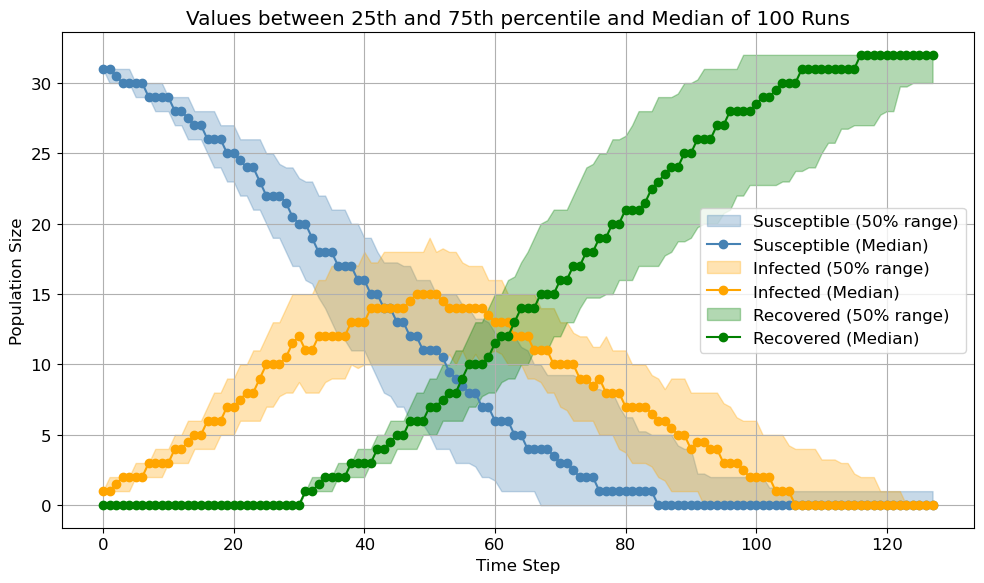

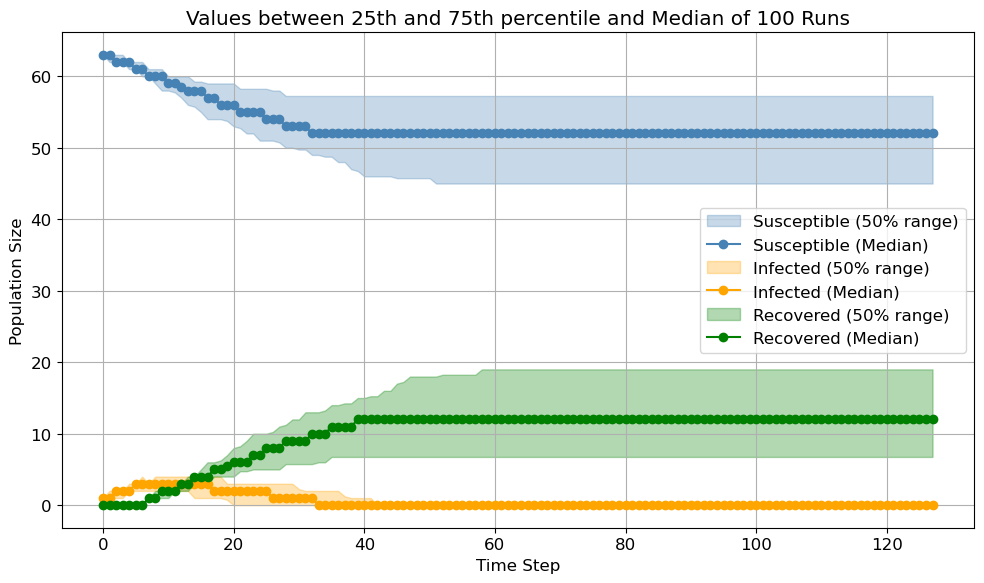

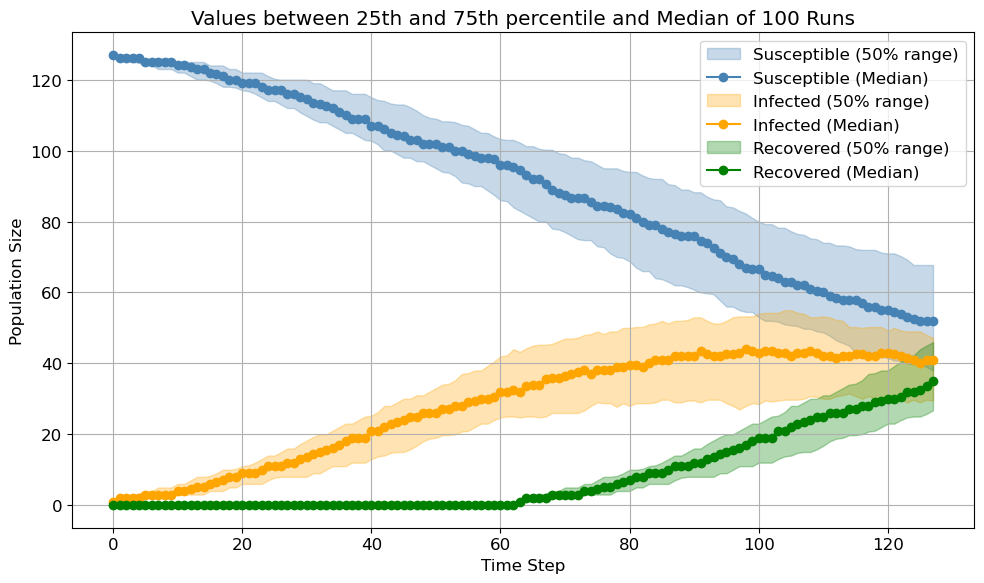

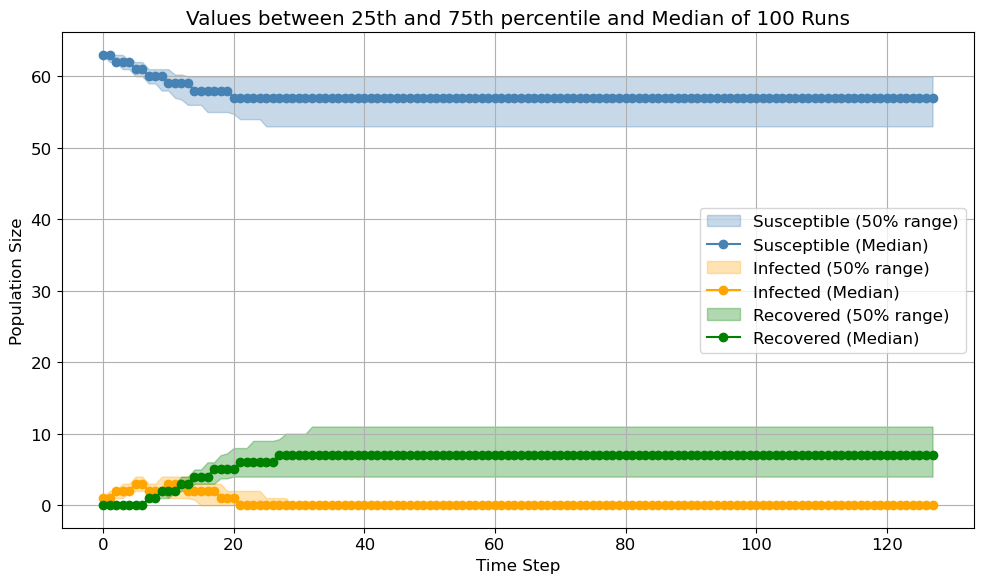

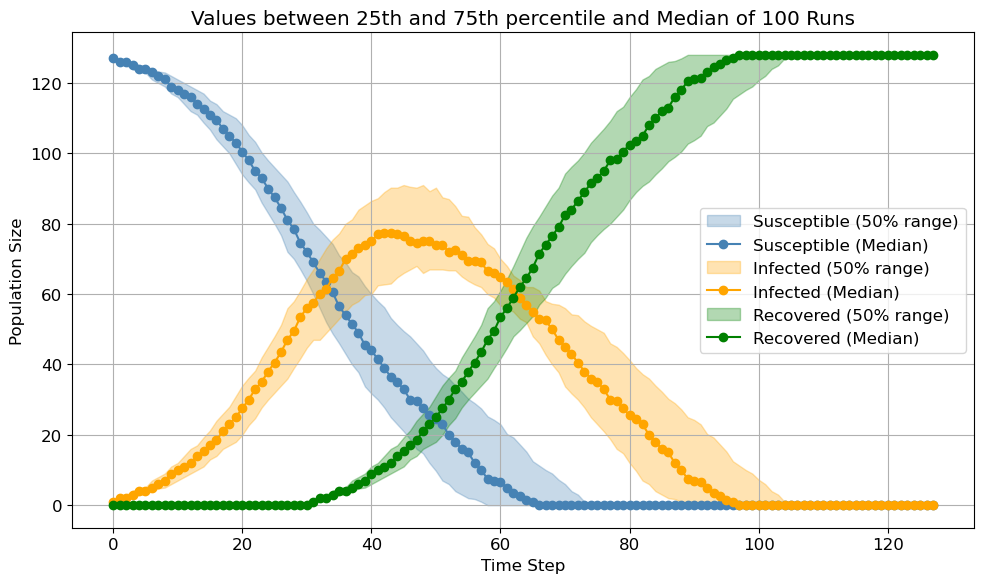

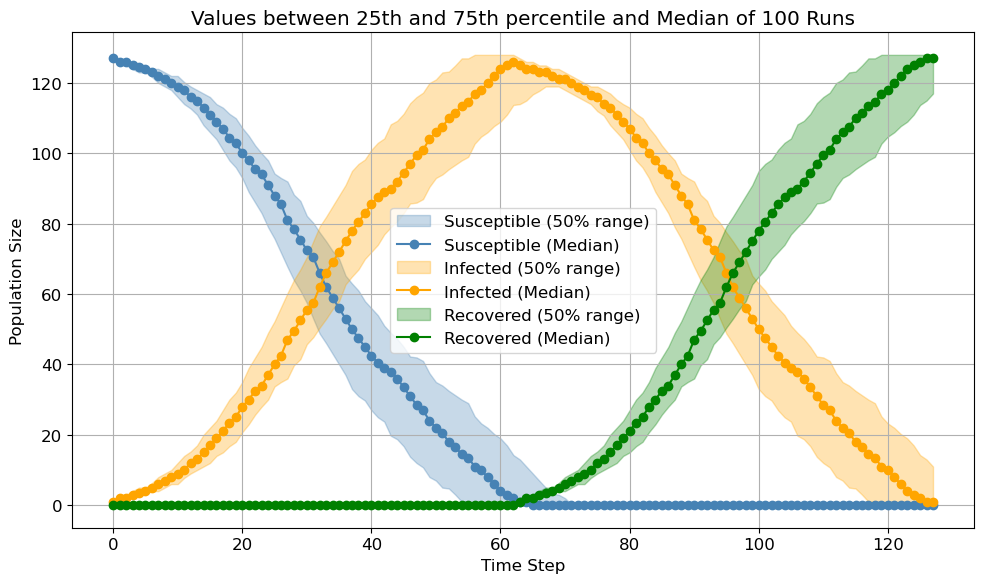

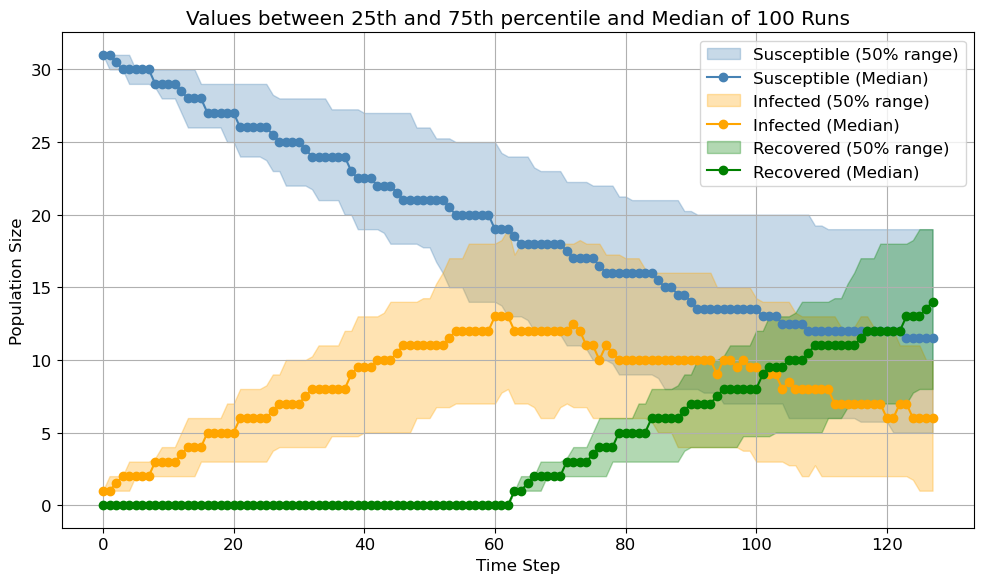

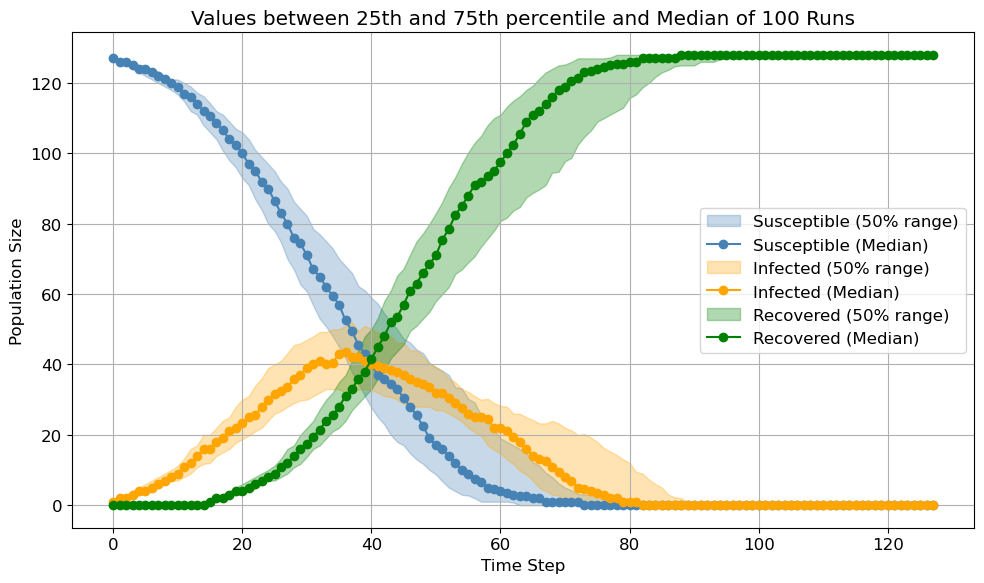

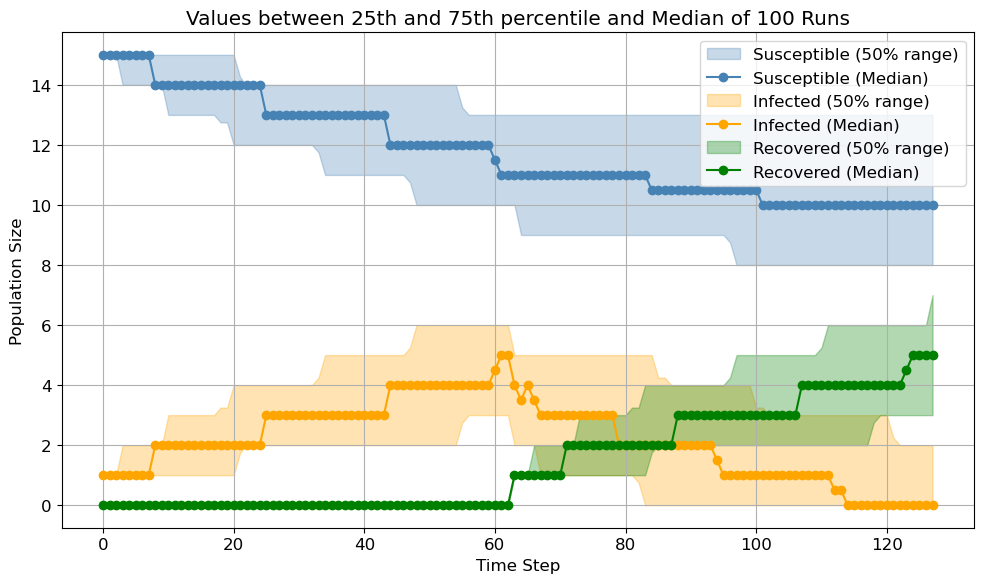

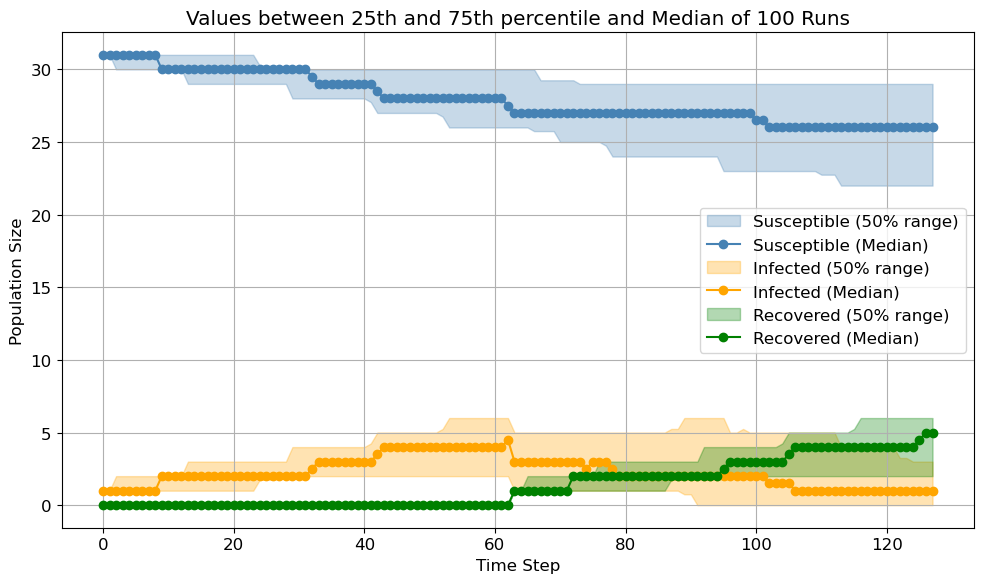

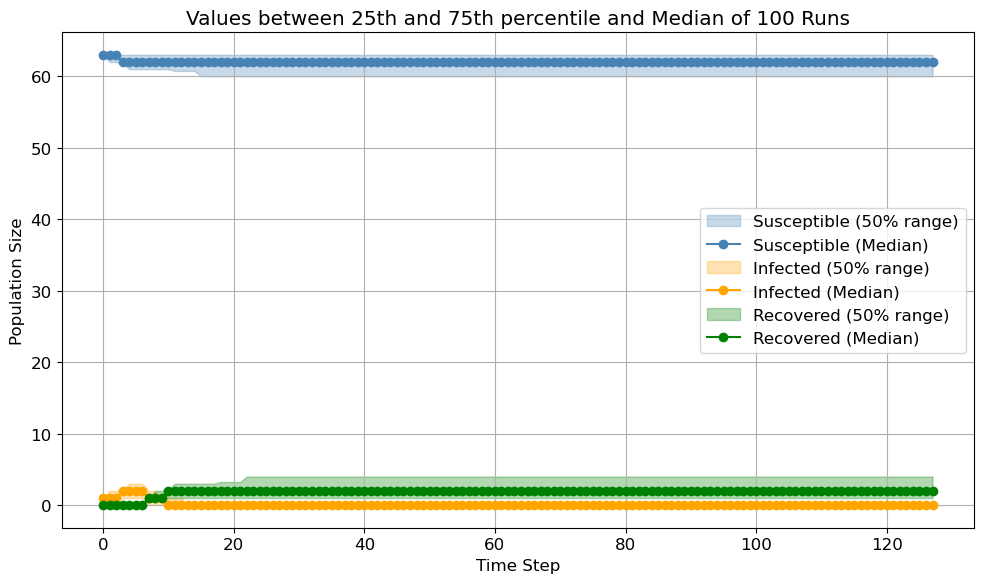

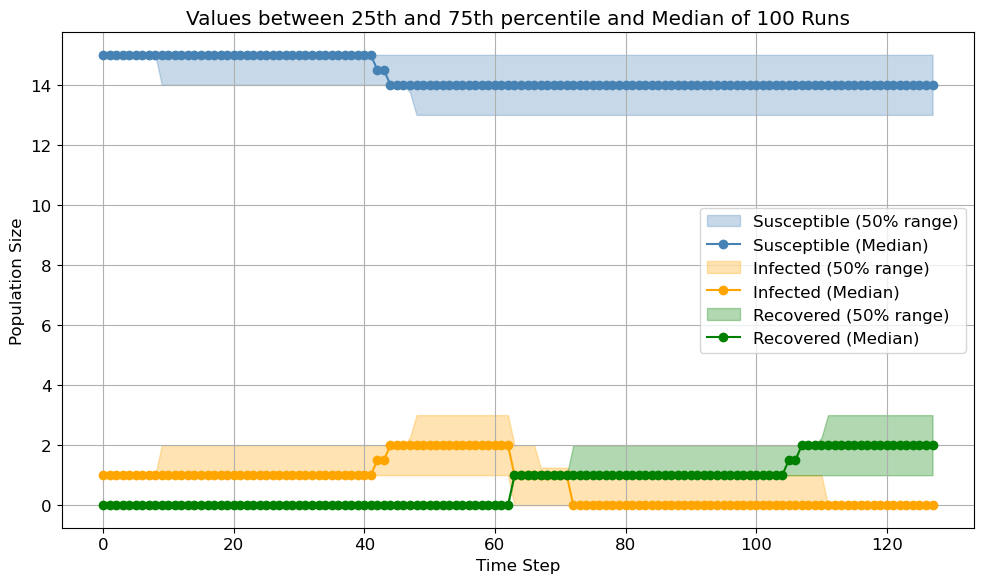

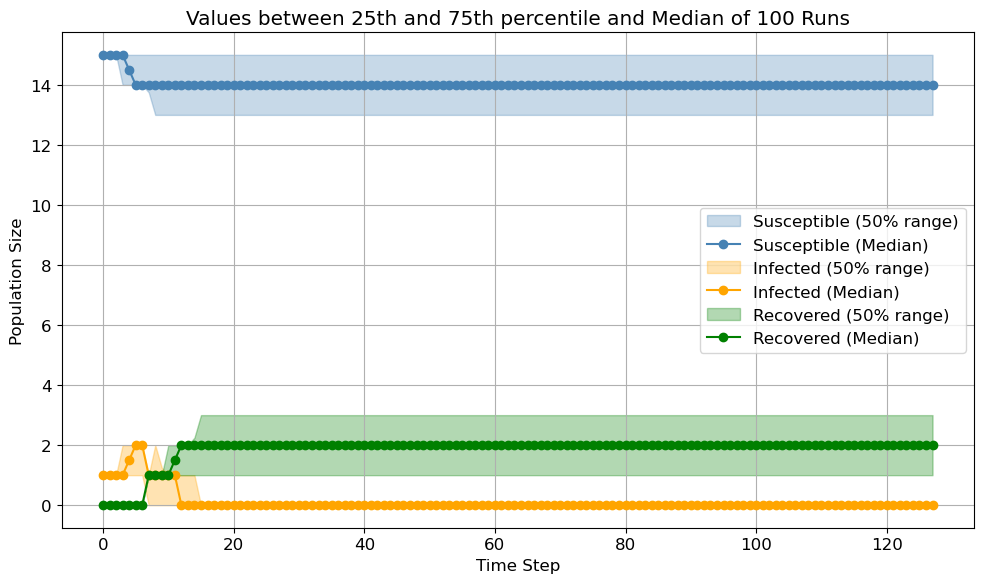

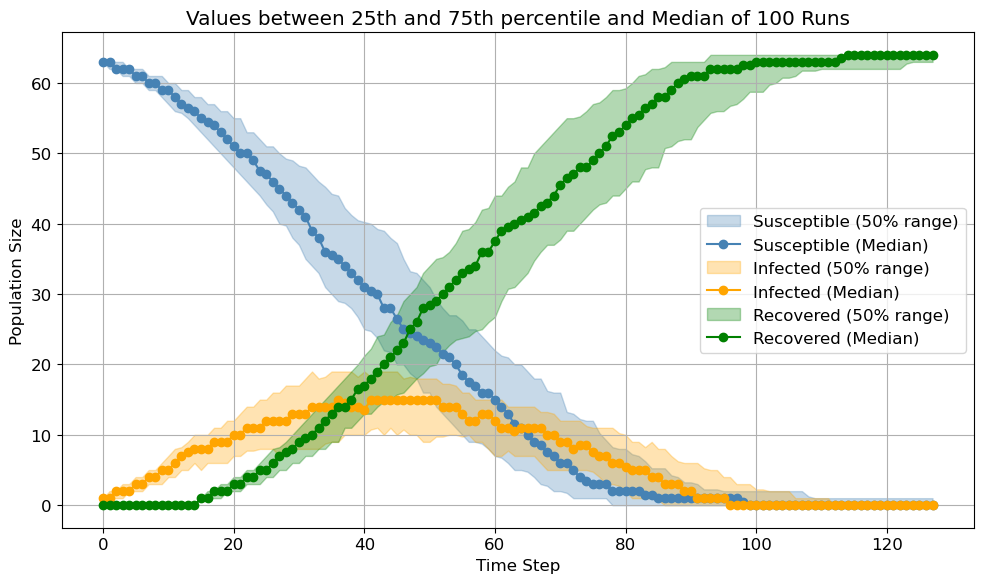

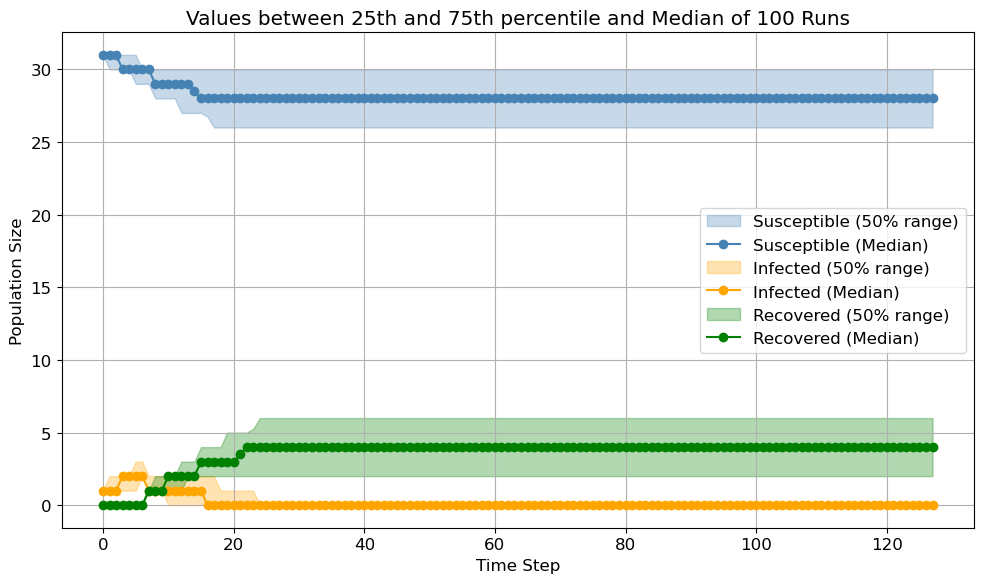

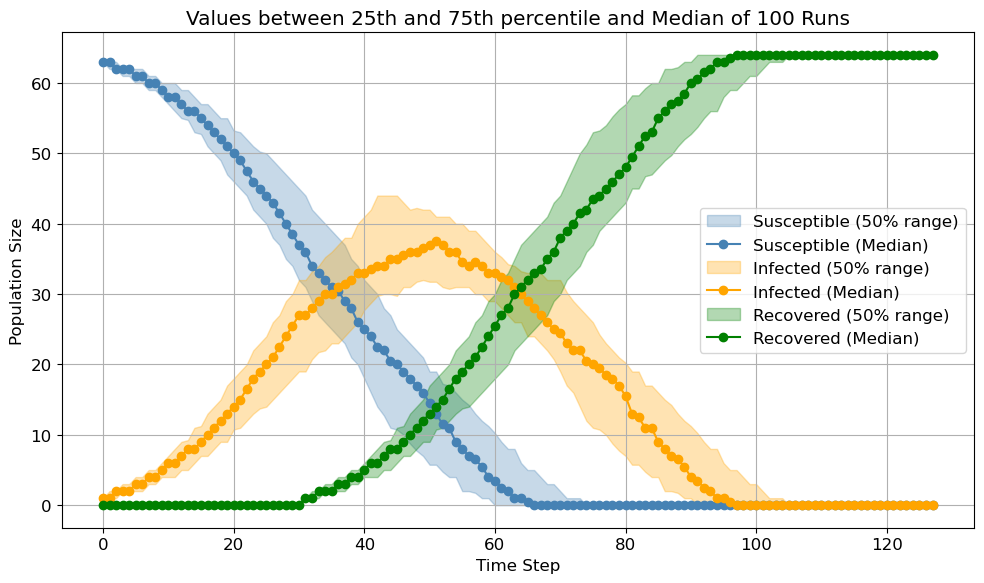

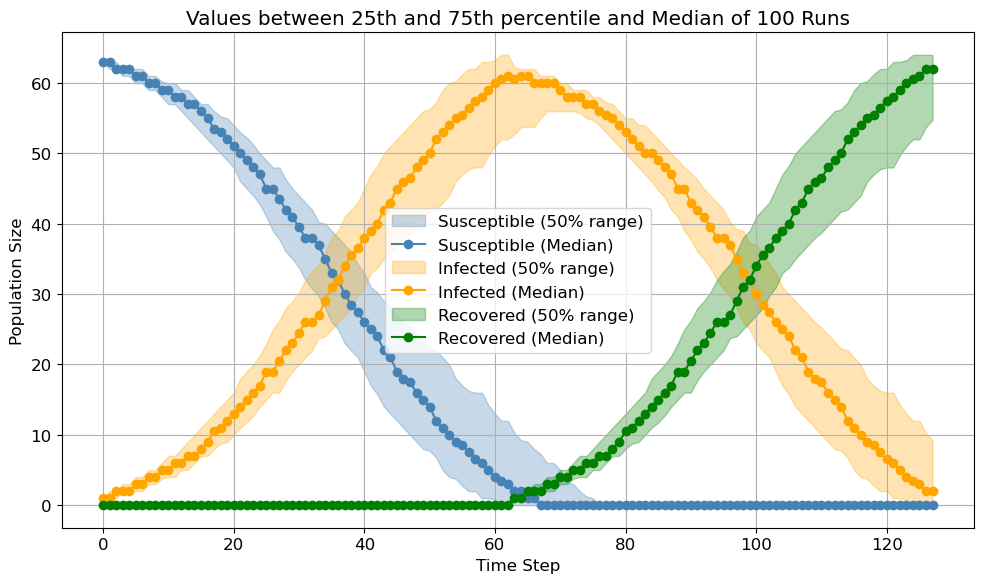

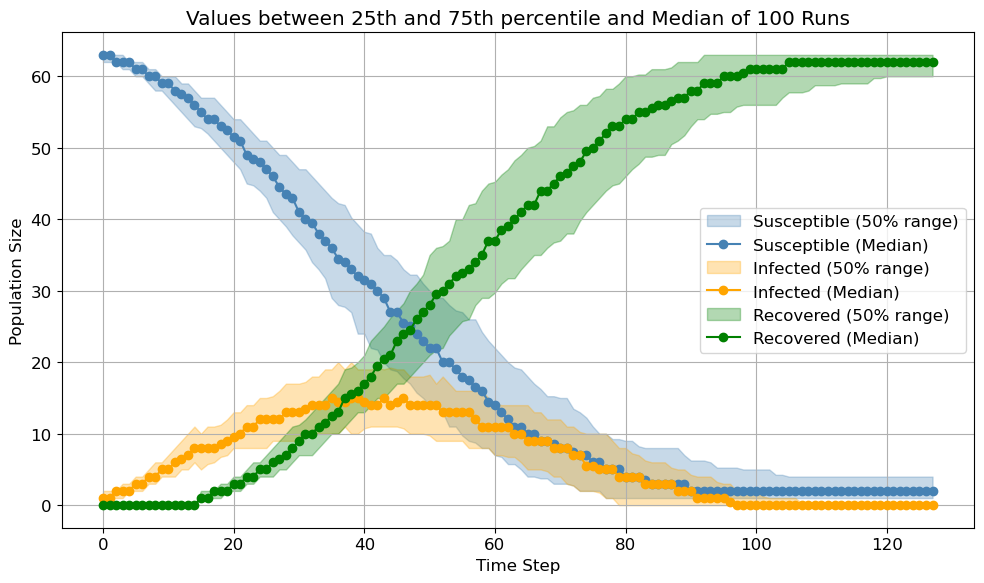

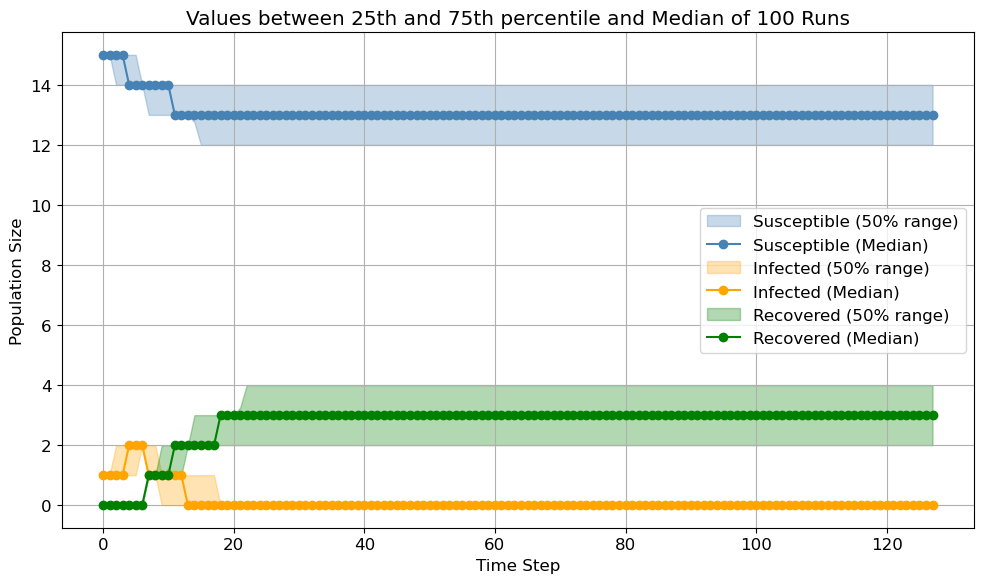

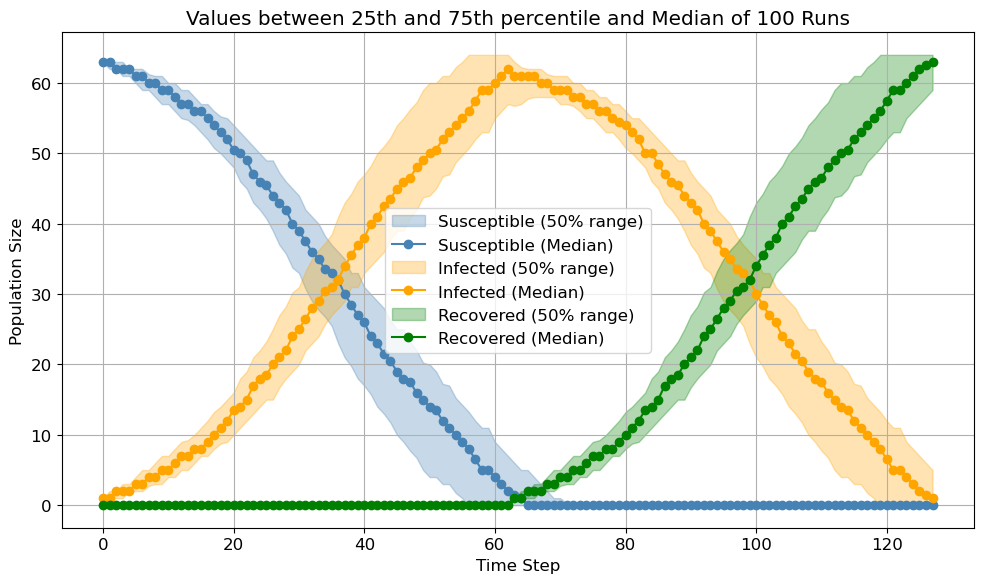

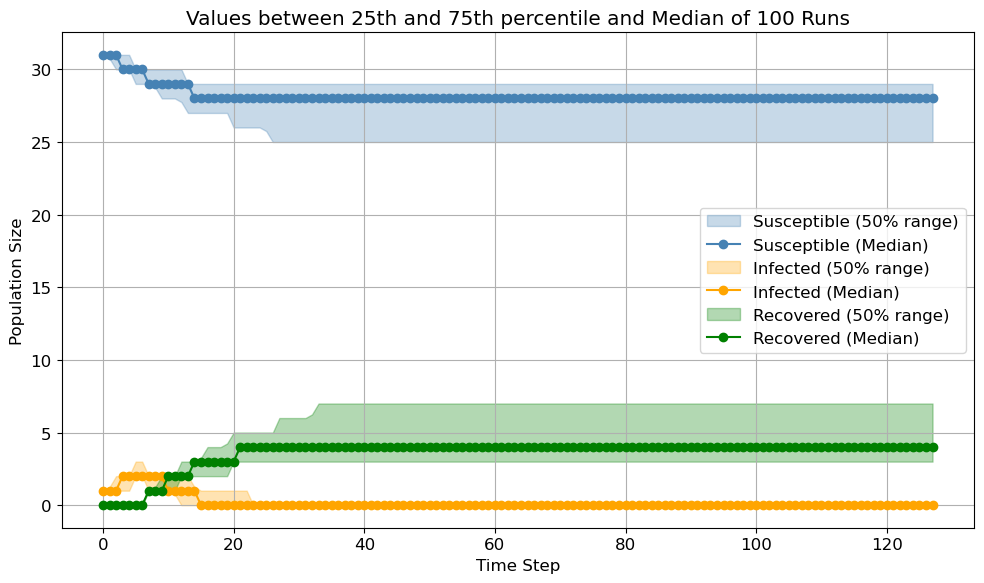

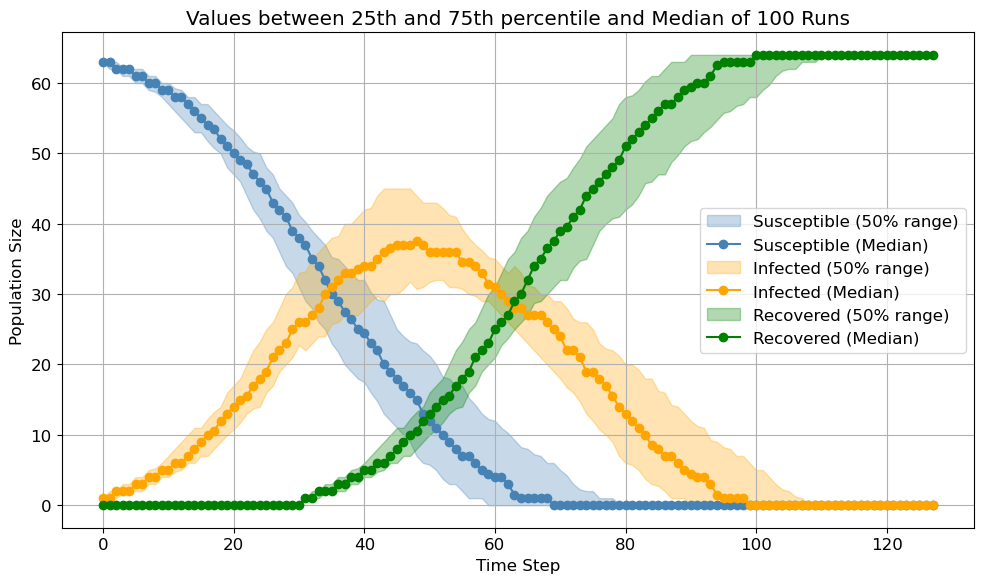

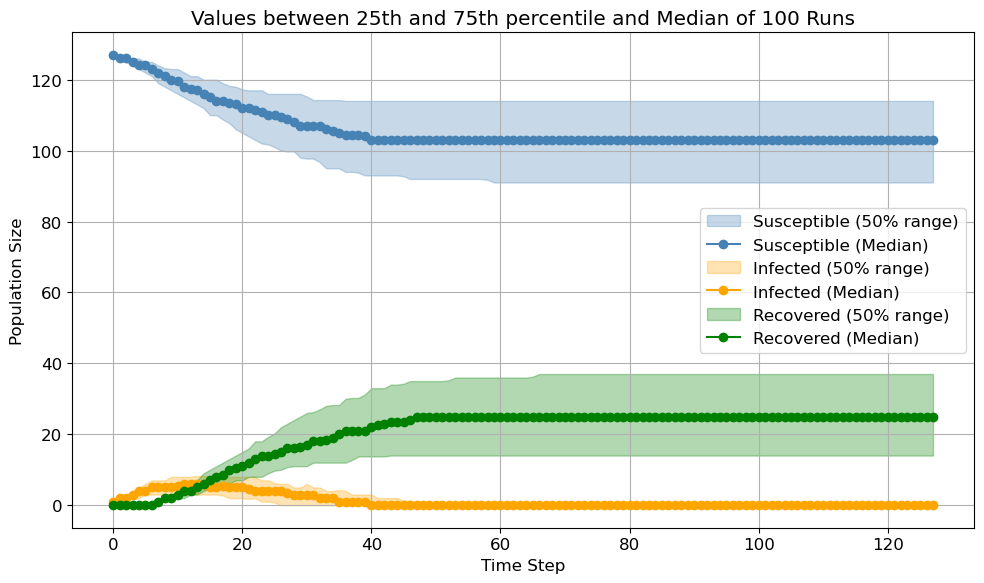

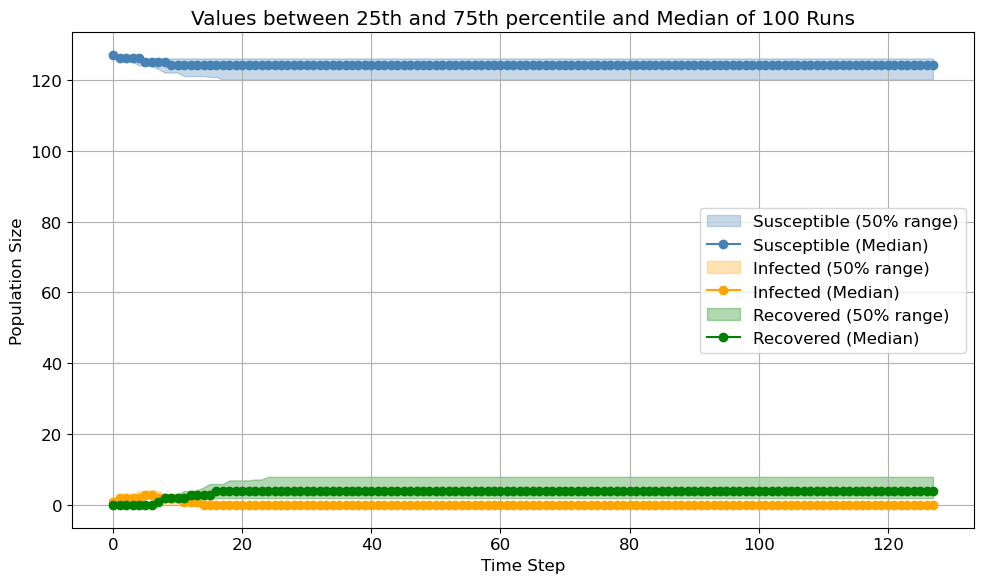

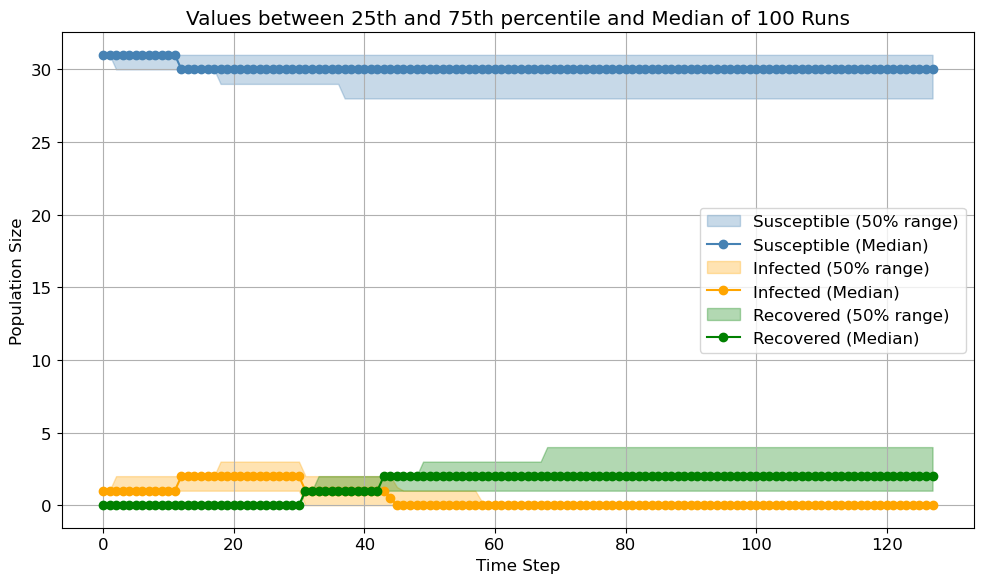

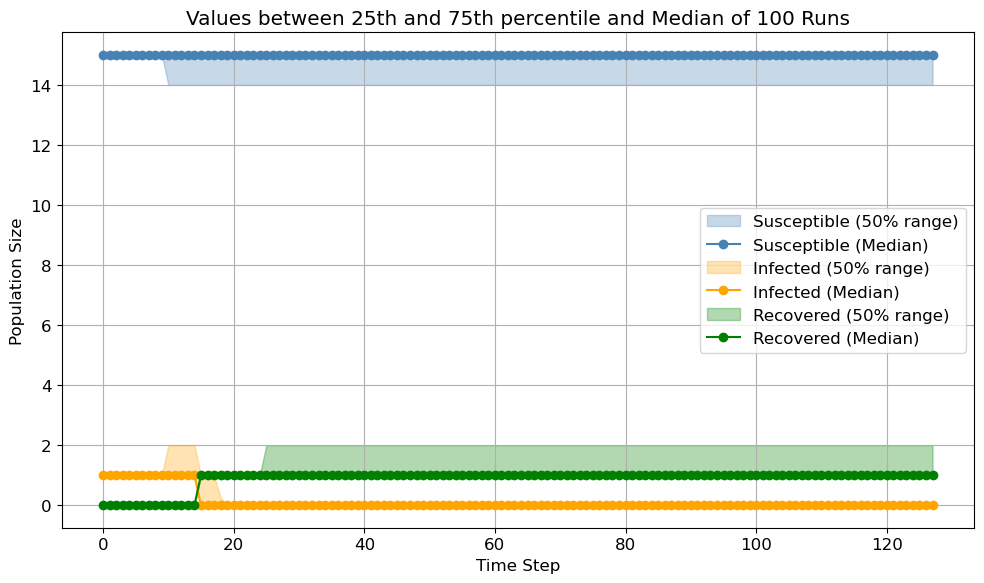

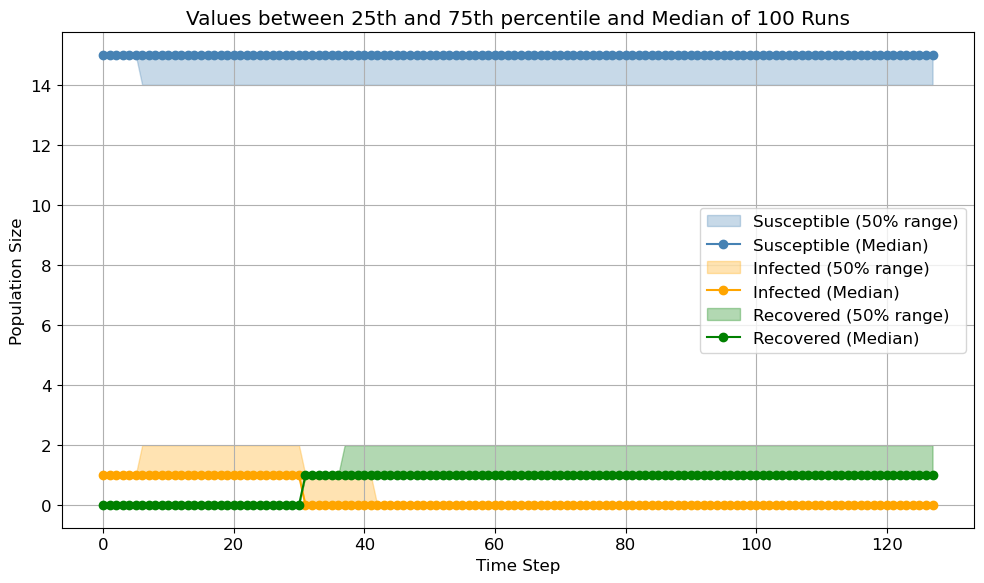

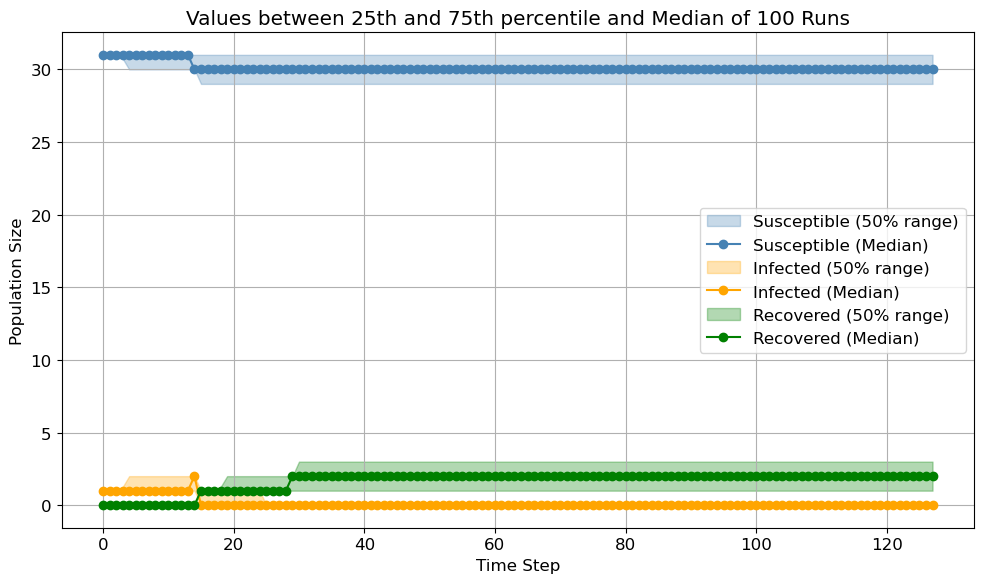

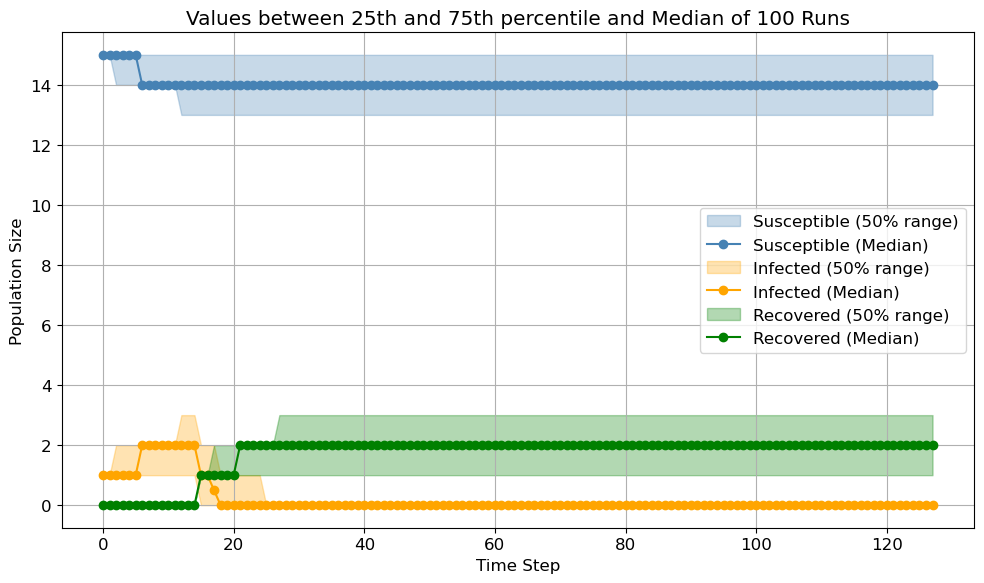

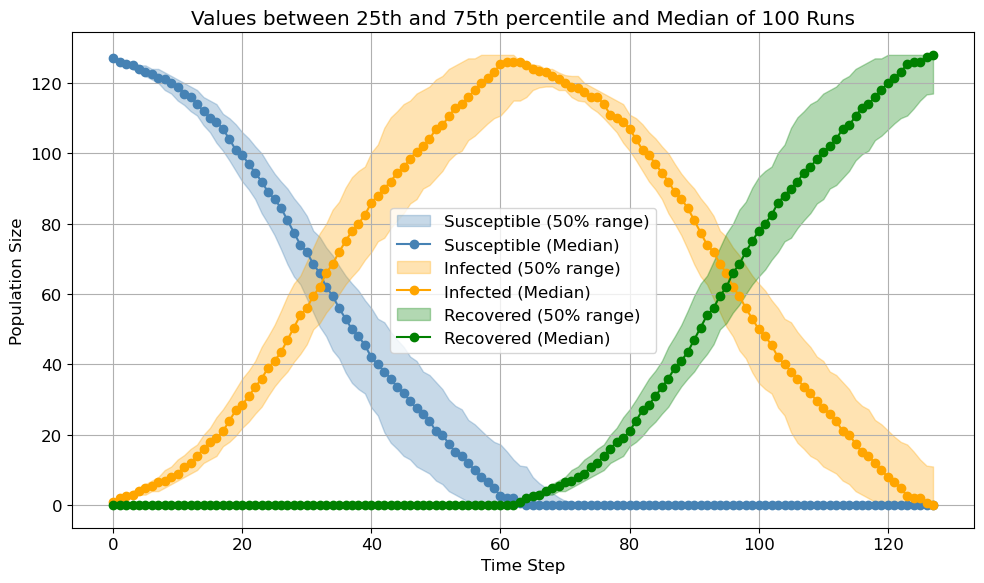

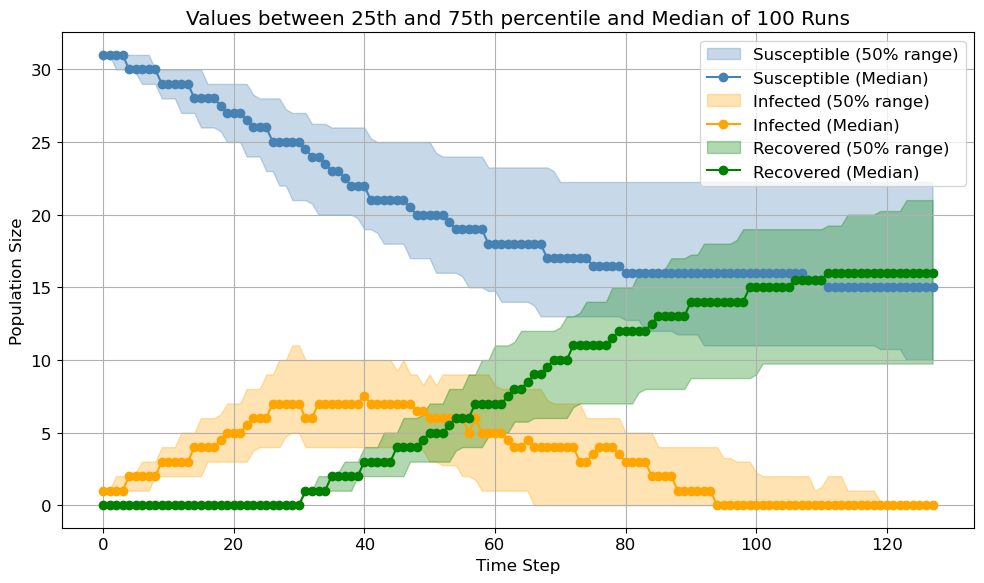

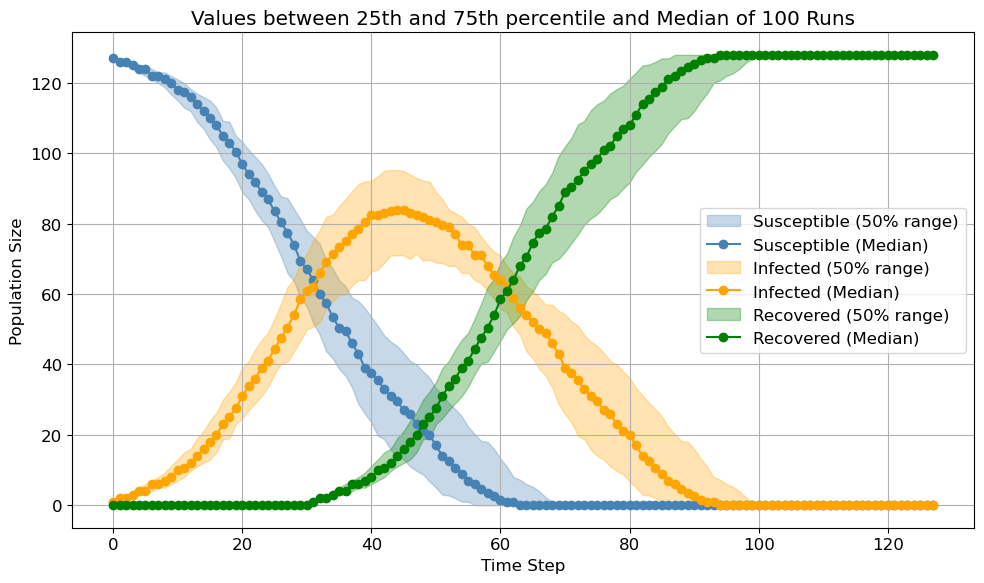

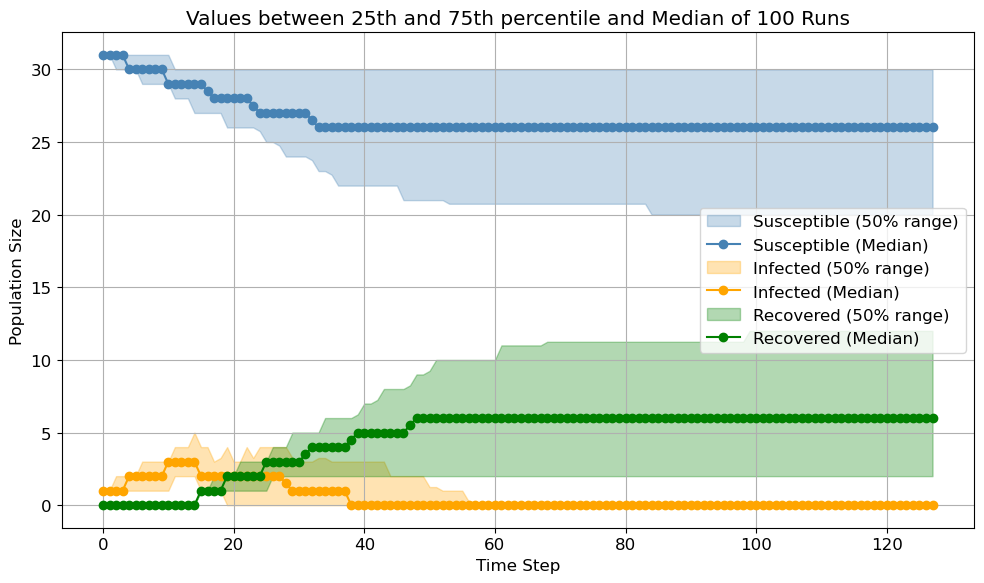

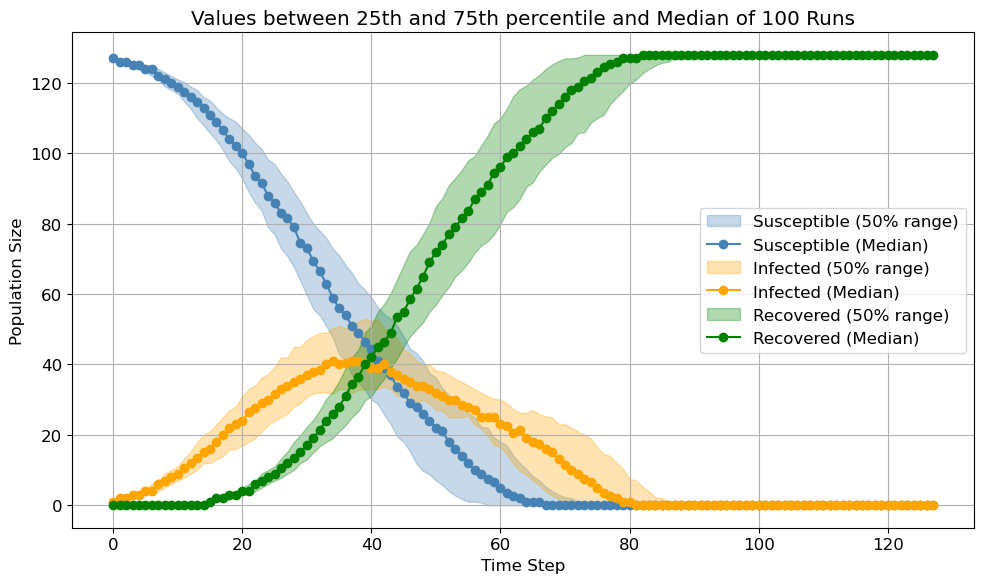

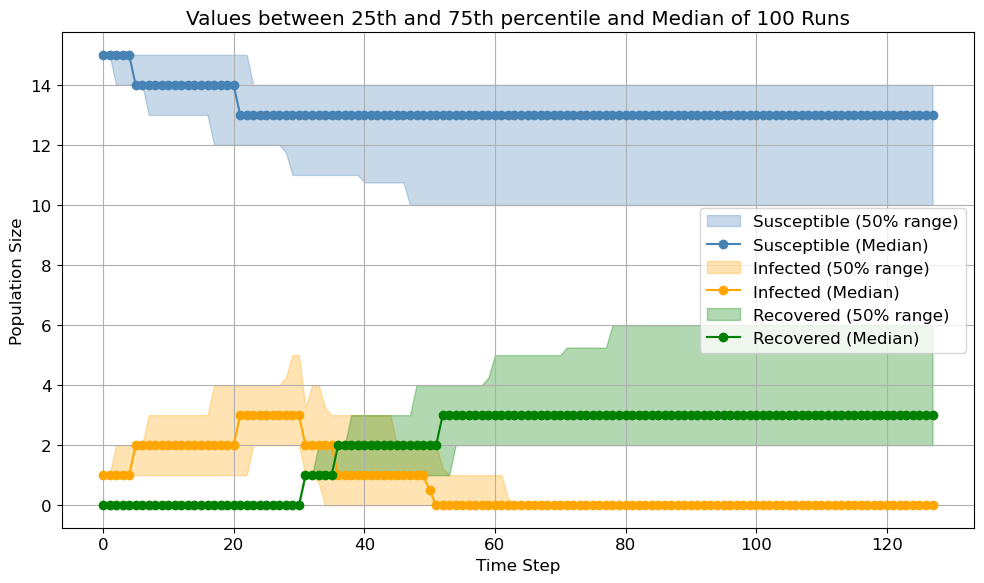

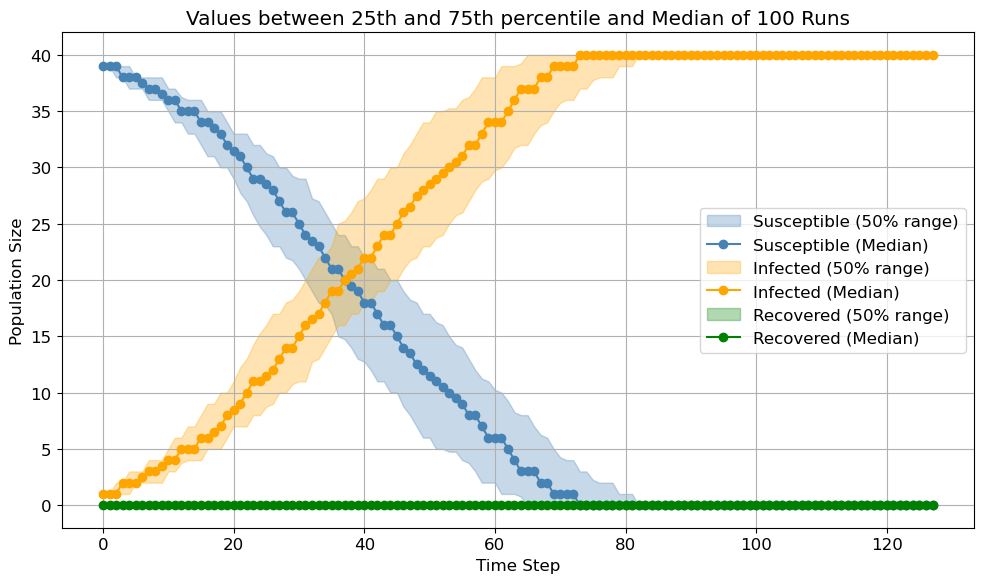

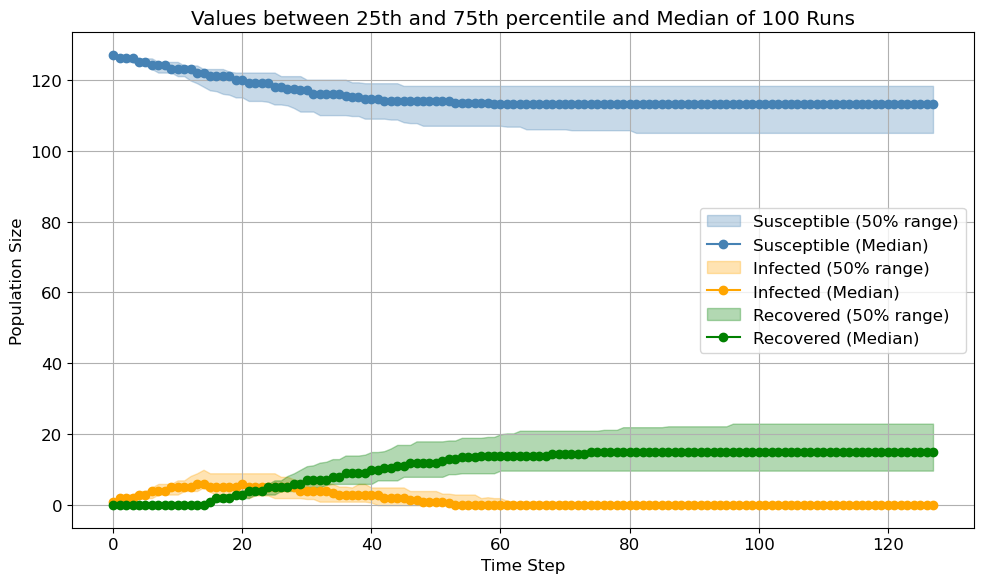

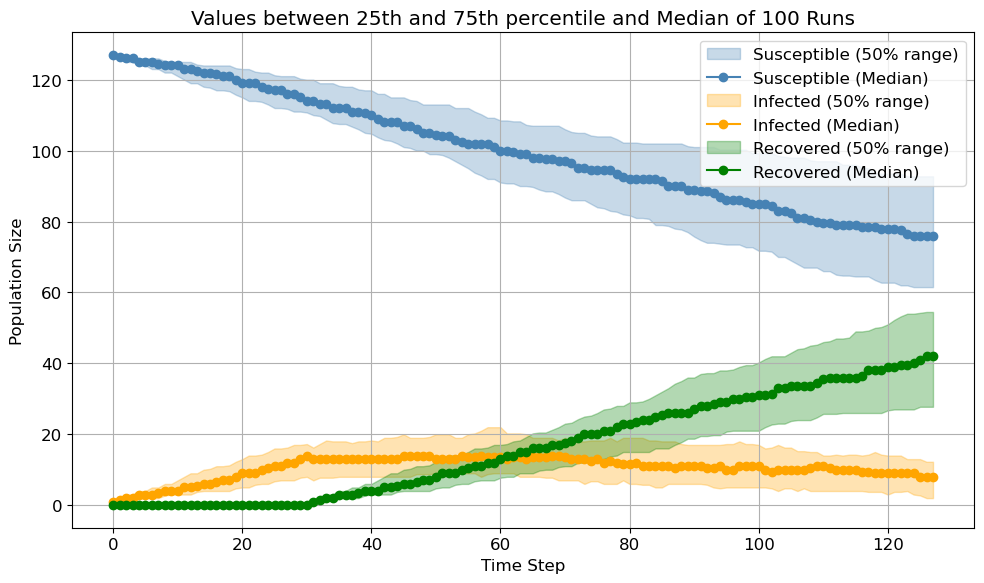

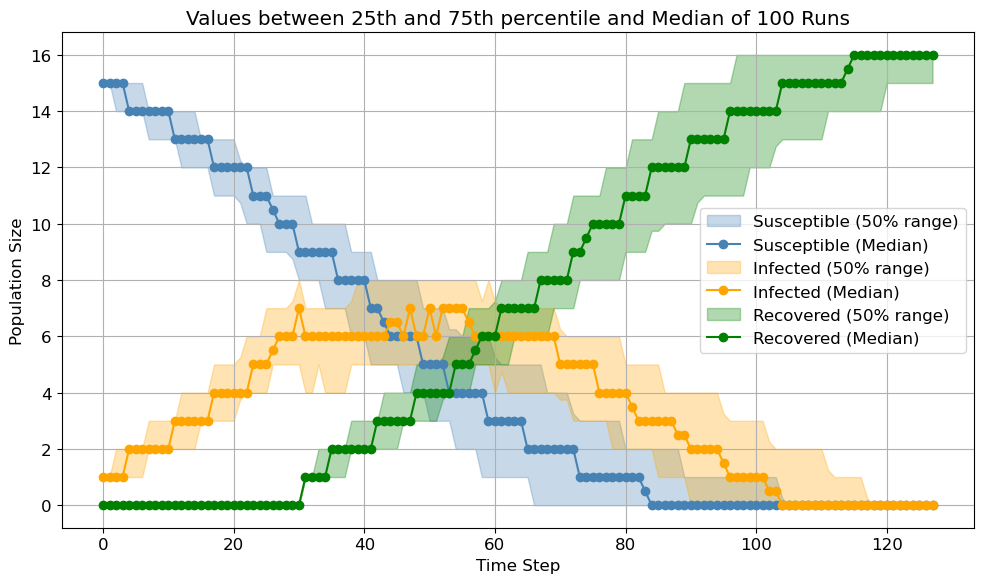

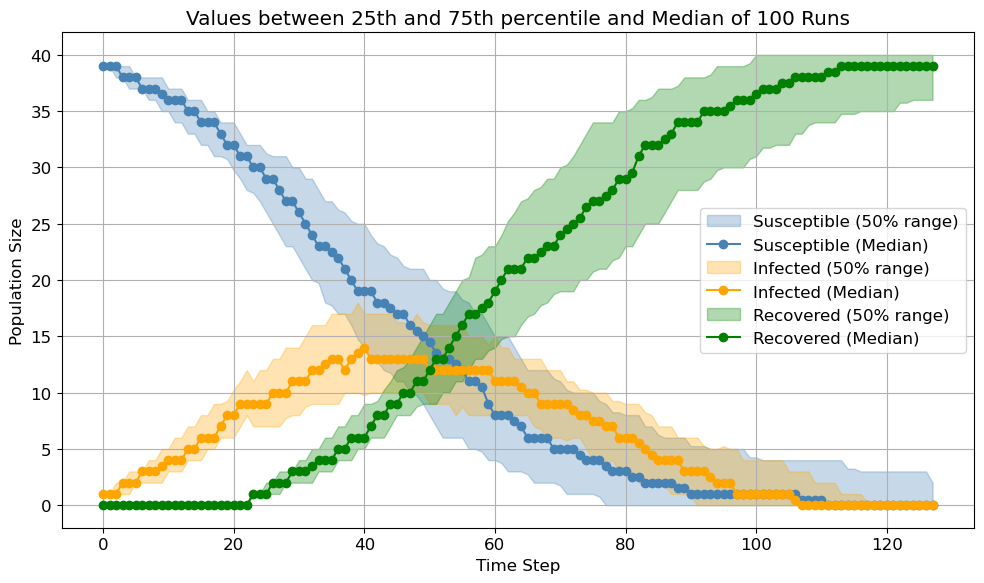

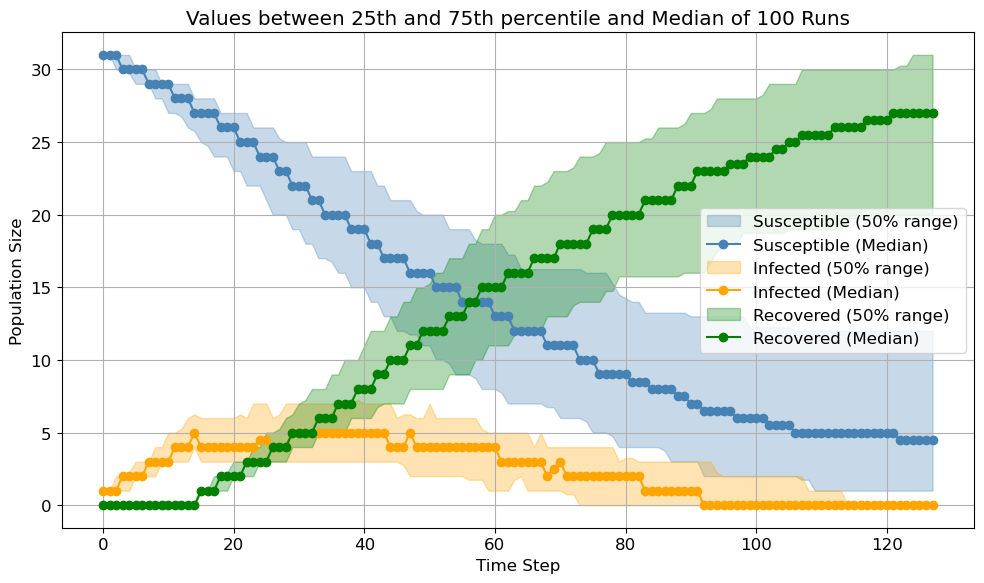

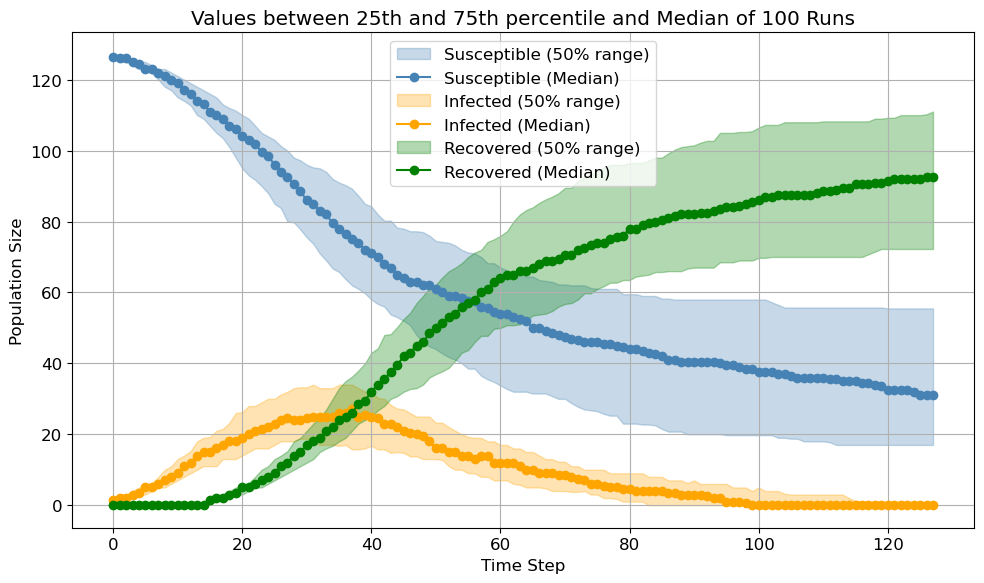

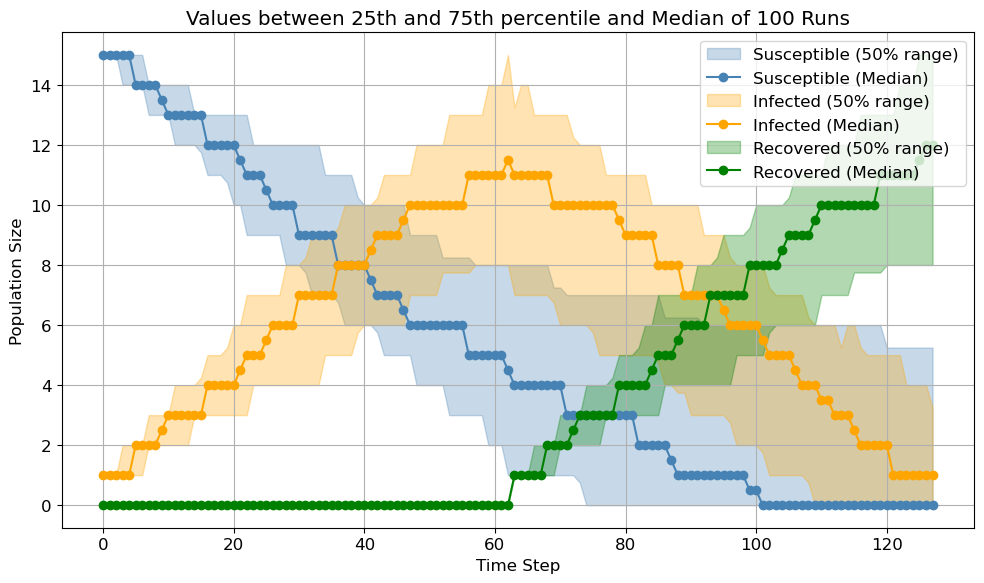

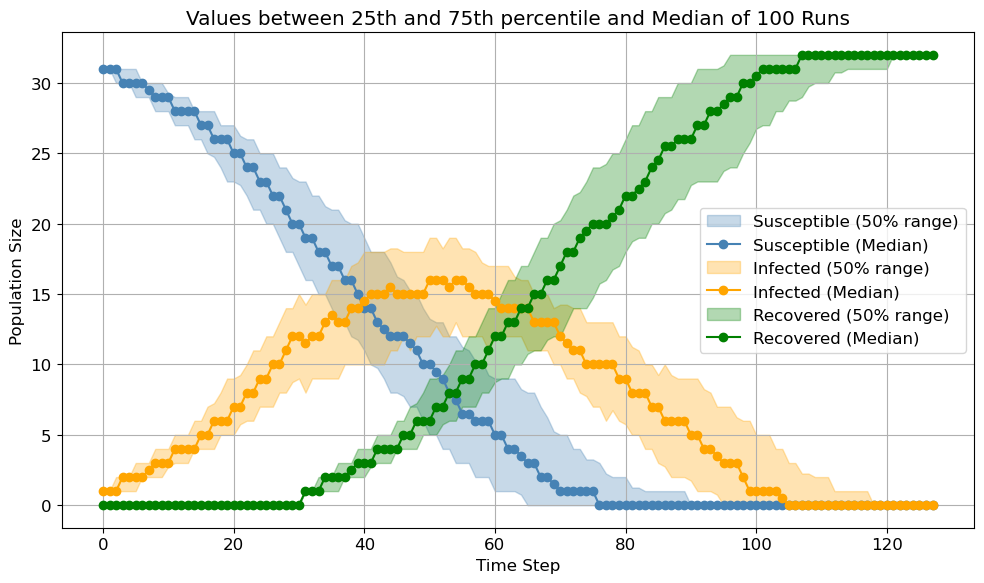

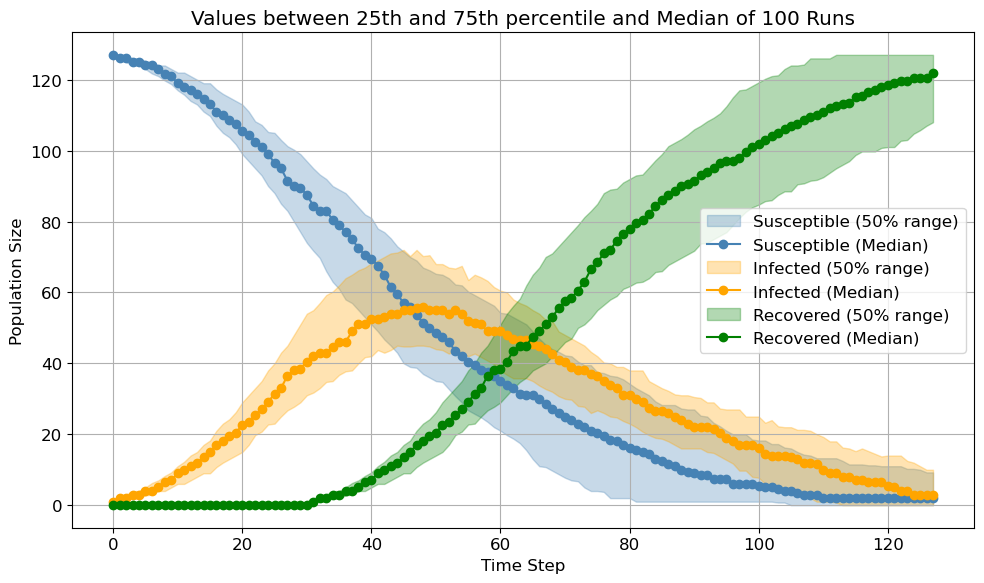

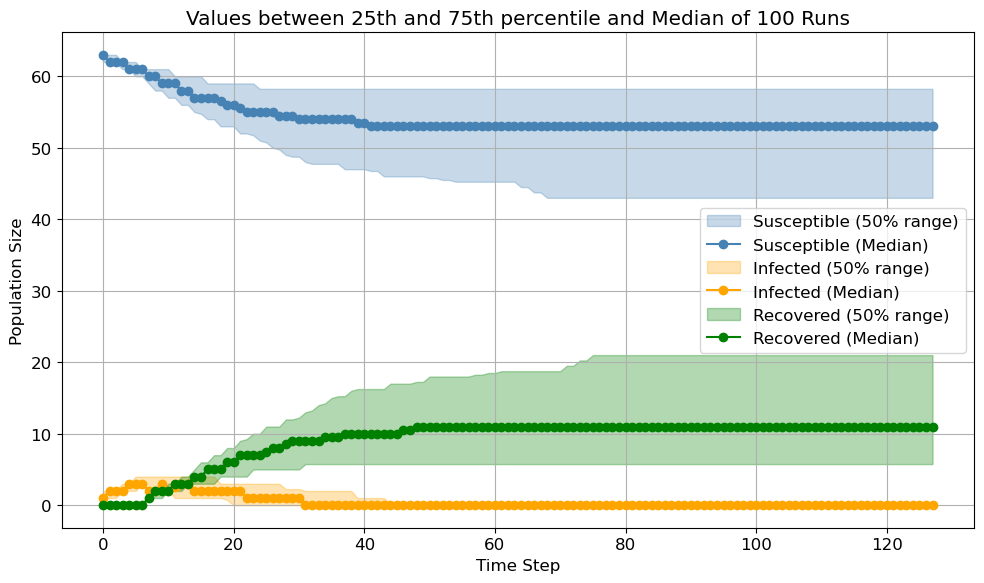

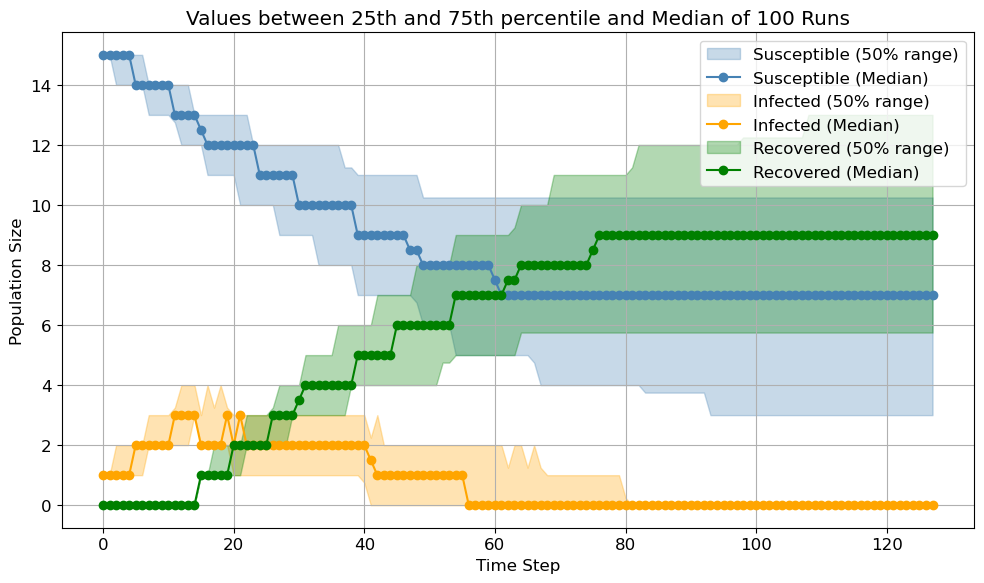

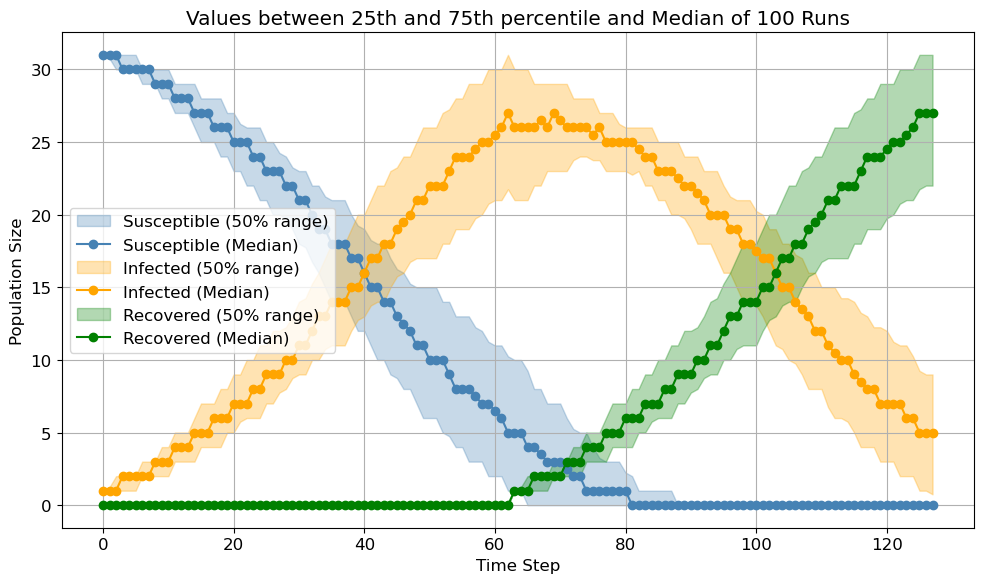

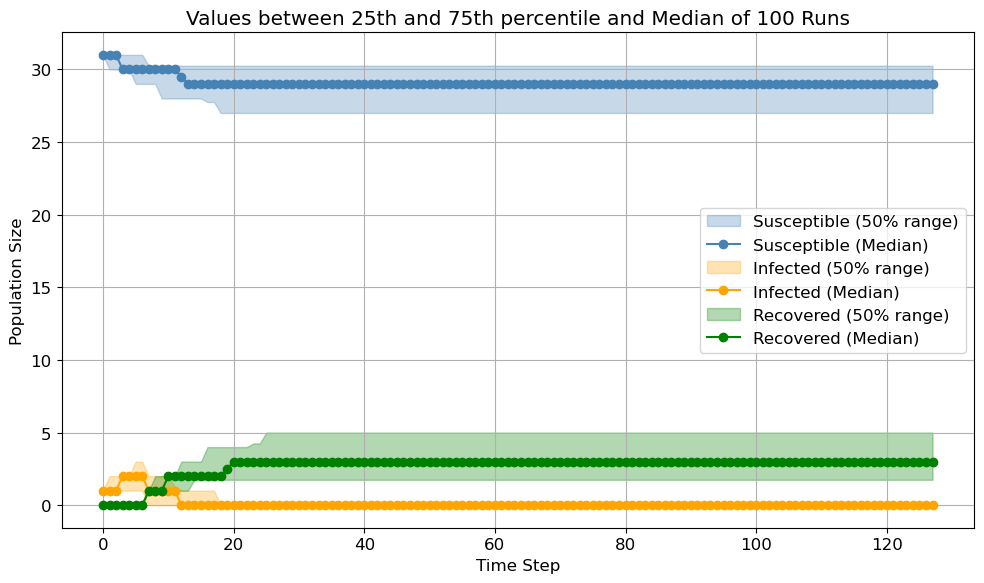

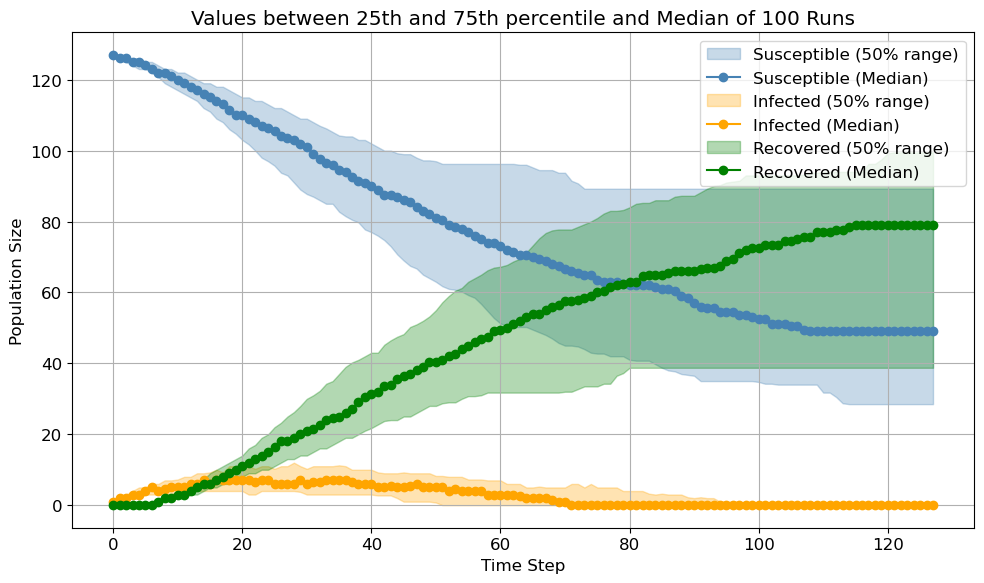

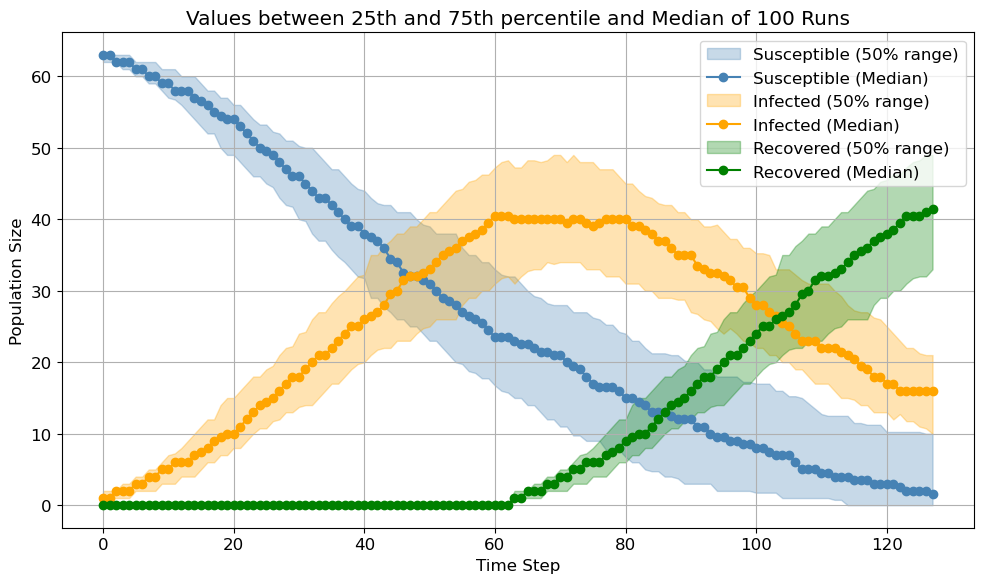

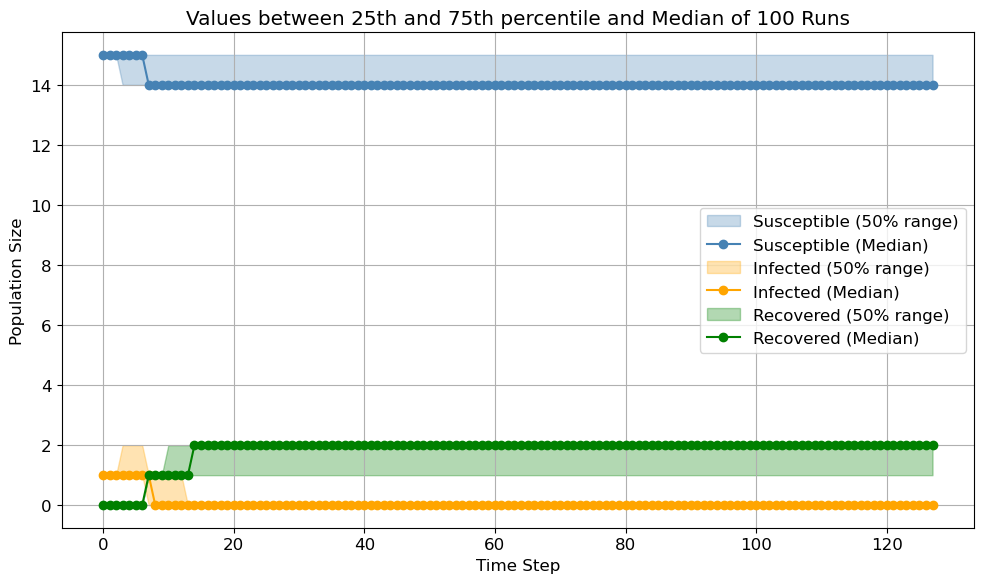

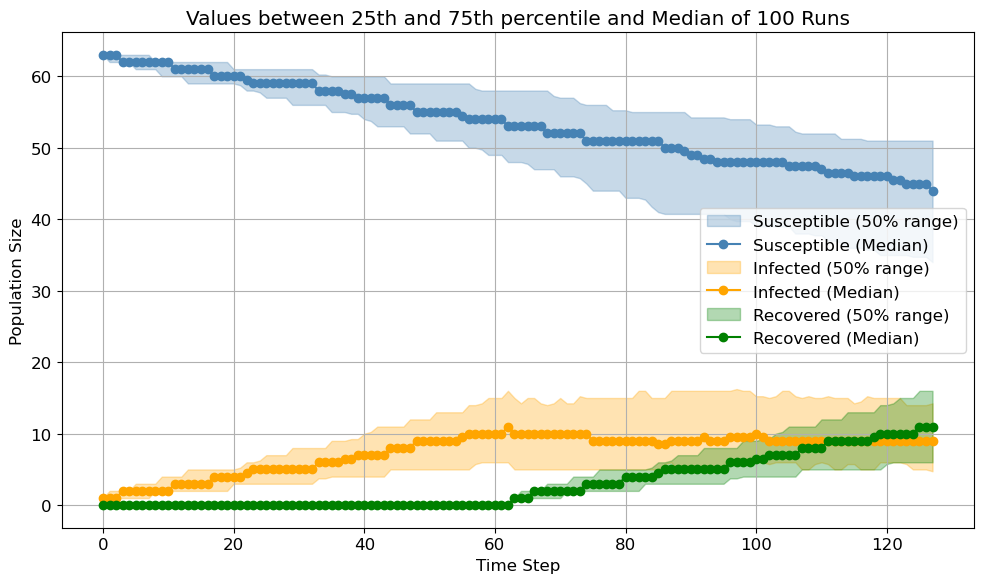

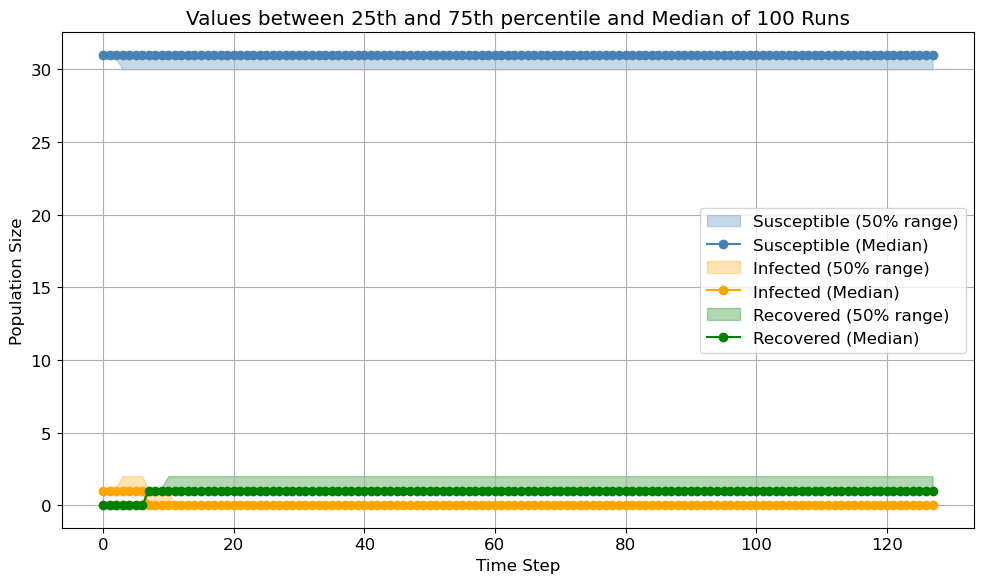

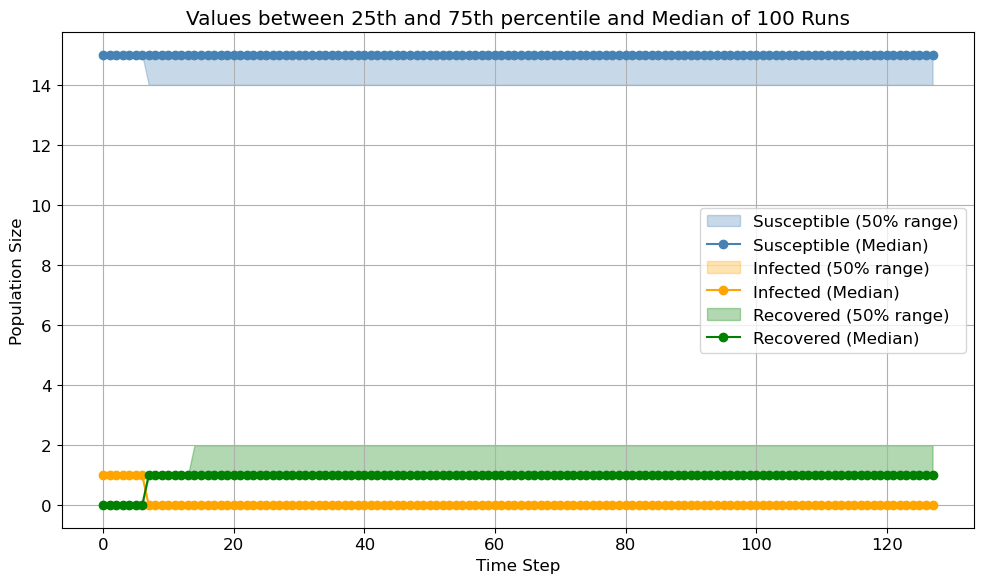

In [104]:
# os.mkdir("experiments")
for exp in os.listdir("../../src/InfoWave.MonoGame/bin/Release/net7.0/experiments"):
    plot_sir_quantile(exp, 0.125, 0.05, False)
    # print(exp)

In [59]:
from PIL import Image
import os
import re

In [70]:
pattern = re.compile("sir_\d+\.png")
paths = [
    "../../../master-thesis/images/chapter2/sir0",
    "../../../master-thesis/images/chapter2/sir2",
    "../../../master-thesis/images/chapter2/sir3"
]
for path in paths:
    for file in os.listdir(path):
        if not pattern.match(file): continue
        im = Image.open(f"{path}/{file}")
        cropped = im.crop((1, 1, 1537, 769))
        cropped.save(f"{path}/{file}")

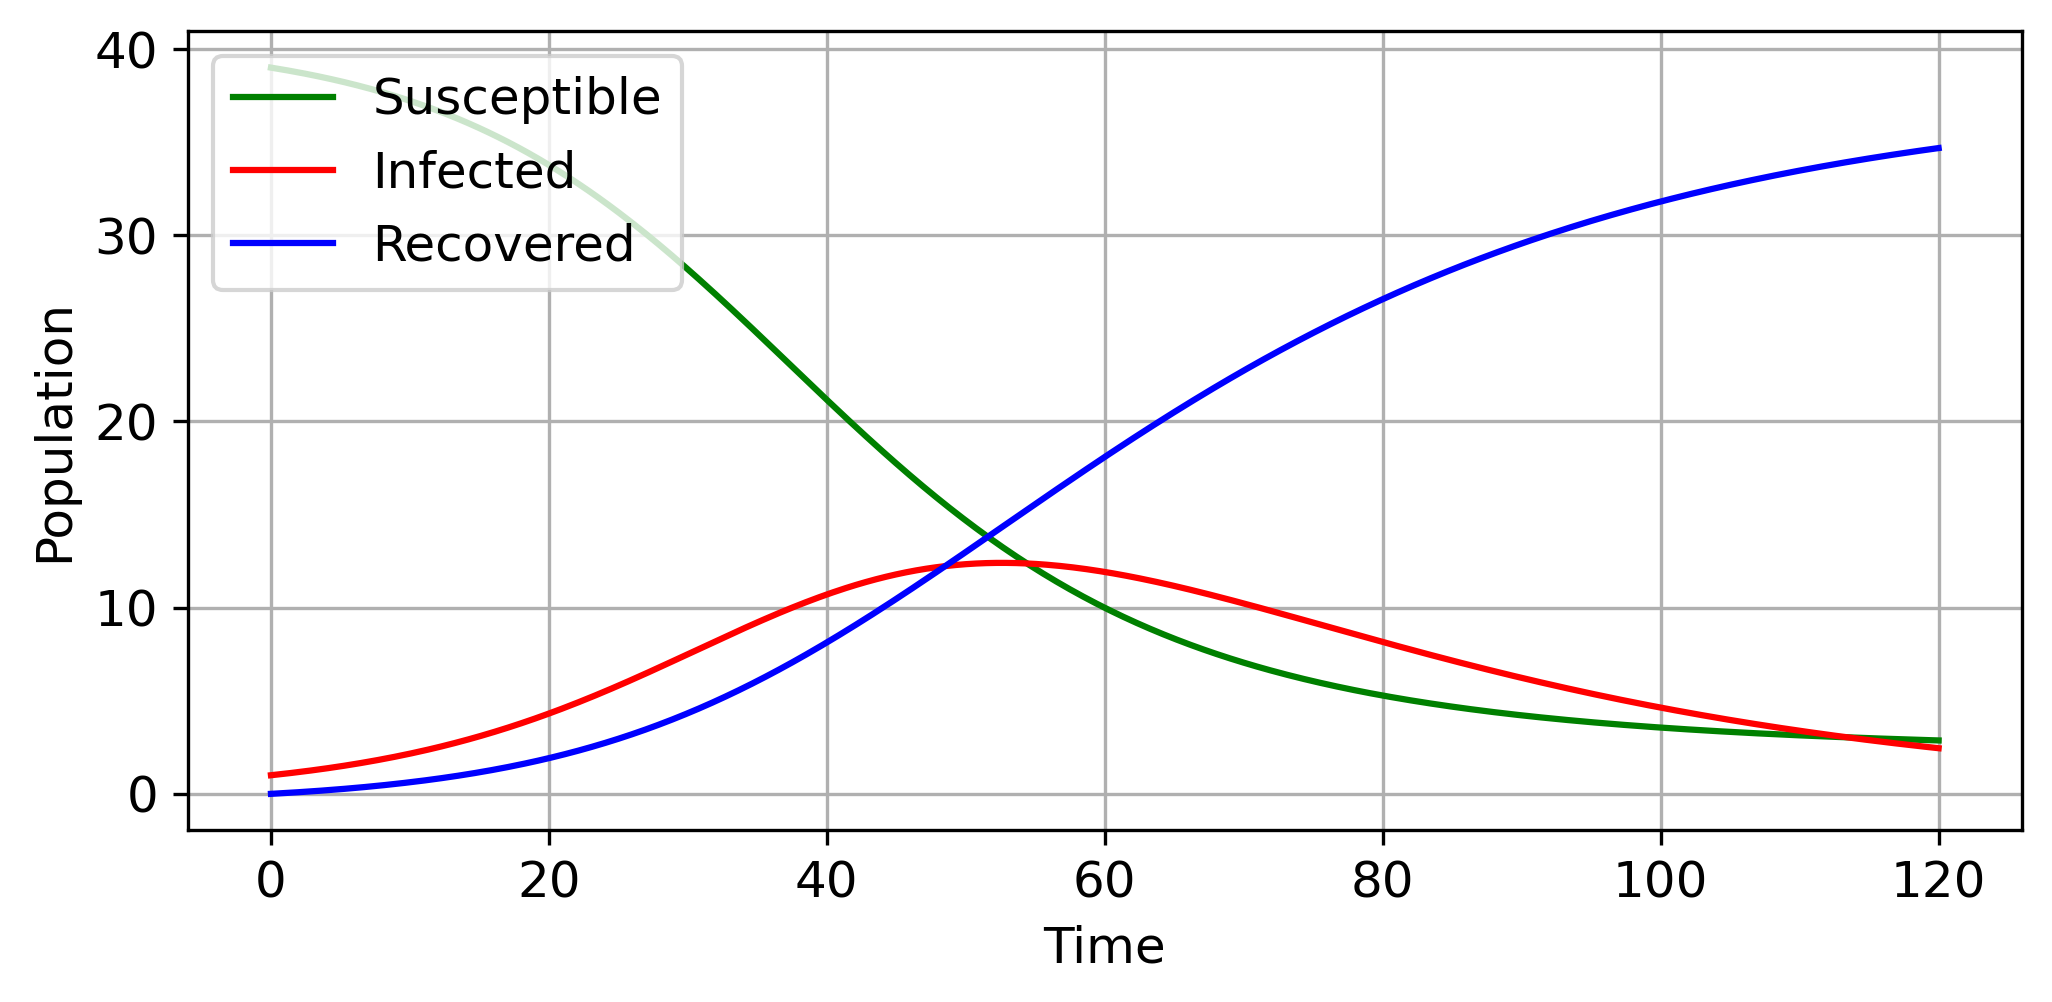

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
beta = 0.03  # Infection rate
gamma = 0.01  # Recovery rate
N = 40  # Total population size

# Initial conditions
S0 = N - 1  # Initial number of susceptible individuals
I0 = 1  # Initial number of infected individuals
R0 = 0  # Initial number of recovered individuals

# Time vector
t = np.linspace(0, 120, 500)  # Time span

# Function for solving the SIR model equations
def solve_sir_model(S, I, R, beta, gamma):
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Solve the SIR model equations
S, I, R = [S0], [I0], [R0]
for i in range(1, len(t)):
    dSdt, dIdt, dRdt = solve_sir_model(S[i-1], I[i-1], R[i-1], beta, gamma)
    S.append(S[i-1] + dSdt)
    I.append(I[i-1] + dIdt)
    R.append(R[i-1] + dRdt)

# Plotting
fig = plt.figure(dpi=300)
plt.plot(t, S, label='Susceptible', c='g')
plt.plot(t, I, label='Infected', c='r')
plt.plot(t, R, label='Recovered', c='b')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig("sir_1.png", format="png", transparent=True, bbox_inches="tight")
